In [1]:
# import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datlib.FRED import *
from datlib.plots import *
import pandas_datareader.data as web


#FRED.py
#. . . 
def bil_to_mil(series):
    return series* 10**3
# . . .
#fedProject.py
# . . .
data_codes  = {# Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Capital
               "Balance Sheet: Total Capital": "WCTCL",
               # Interest Rates
               "Unemployment Rate": "UNRATE",
                "$U_N$": "NROU",
                "Nominal GDP ($ Bil)":"GDP",
               "Real GDP ($ Bil)":"GDPC1",
                "Potential GDP": "NGDPPOT",
               "GDP Deflator":"GDPDEF",
               "CPI":"CPIAUCSL",
               "Core PCE":"PCEPILFE",
               "Private Investment":"GPDI",
               "Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Bil)": "WCURCIR",
               "1 Month Treasury Rate (%)": "DGS1MO",
               "3 Month Treasury Rate (%)": "DGS3MO",               
               "1 Year Treasury Rate (%)": "DGS1",
               "2 Year Treasury Rate (%)": "DGS2",
               "10 Year Treasury Rate (%)": "DGS10",
               "30 Year Treasury Rate (%)": "DGS30",               
               "Effective Federal Funds Rate (%)": "DFF",
               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
               "Federal Funds Upper Target":"DFEDTARU",
               "Federal Funds Lower Target":"DFEDTARL",
               "Interest on Reserves (%)": "IOER",
               "VIX": "VIXCLS",
                "5 Year Forward Rate": "T5YIFR",    
               }

inflation_target = 2

# Select start and end dates
start = datetime.datetime(2000, 1, 1)
# end = datetime.datetime(2020, 8, 31)
end = datetime.datetime.today()

## year variable automatically adjusts the numper of periods  
#   per year in light of data frequency
annual_div = {"Q":4,
             "W":52,
             "M":12}
### choose frequency
freq = "M"
### set periods per year
year = annual_div[freq]


In [2]:

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days

if "data_gathered" not in locals():
    data = gather_data(data_codes, start, 
          end = end, freq = freq)
    data["$U_N$"] = data["$U_N$"].interpolate(method='linear')
    
    data.fillna(0, inplace=True)
    for key in data.keys():
        data["Log " + key]= np.log(data[key])
    data_gathered = True
unemployment_target = data["$U_N$"]

data["Base: Currency in Circulation ($ Mil)"] = data["Base: Currency in Circulation ($ Bil)"].mul(1000)
data["Base: Currency not in Circulation ($ Mil)"] = data["Base: Total ($ Mil)"].sub(data["Base: Currency in Circulation ($ Mil)"])
data["Currency in Circulation Growth Rate (%)"] = data["Base: Currency in Circulation ($ Mil)"].pct_change(year) * 100
data["Currency in Circulation Growth Rate Diff (%)"] =  data["Currency in Circulation Growth Rate (%)"].diff(year)
data["Currency in Circulation Growth Rate Diff-in-Diff (%)"] =  data["Currency in Circulation Growth Rate Diff (%)"].diff(year)

data["% Currency not in Circulation"] = data["Base: Currency not in Circulation ($ Mil)"].div(data["Base: Total ($ Mil)"]) * 100
data["% Currency in Circulation"] = data["Base: Currency in Circulation ($ Mil)"].div(data["Base: Total ($ Mil)"]) * 100
data["Base: Total Growth Rate (%)"] = data["Base: Total ($ Mil)"]
data["Change % Currency not in Circulation"] = data["% Currency not in Circulation"].diff(year)    
data["Currency not in Circulation Growth Rate (%)"] = data["Base: Currency not in Circulation ($ Mil)"].pct_change(year) * 100    
data["Inflation (CPI)"] =  web.DataReader("CPIAUCSL", "fred", start, end).resample(freq).mean().pct_change(year).mul(100)
data["Inflation (PCE)"] = web.DataReader("PCEPILFE", "fred", start, end).resample(freq).mean().pct_change(year).mul(100)

data["Effective Federal Funds Rate Diff (%)"] = data["Effective Federal Funds Rate (%)"].diff(year)
data["Effective Federal Funds Rate Diff-in-Diff (%)"] = data["Effective Federal Funds Rate Diff (%)"].diff(year)
data["1 Year Treasury Rate (%; diff)"] = data["1 Year Treasury Rate (%)"].diff(year)
data["2 Year Treasury Rate (%; diff)"] = data["2 Year Treasury Rate (%)"].diff(year)
data["10 Year Treasury Rate (%; diff)"] = data["10 Year Treasury Rate (%)"].diff(year)
data["30 Year Treasury Rate (%; diff)"] = data["30 Year Treasury Rate (%)"].diff(year)
data["Unemployment Rate Diff"] = data["Unemployment Rate"].diff(year)
data["Unemployment Rate Diff-in-Diff"] = data["Unemployment Rate Diff"].diff(year)
data["Nominal GDP ($ Mil)"] = data["Nominal GDP ($ Bil)"].mul(1000)
data["Nominal GDP Growth Rate (%)"] = data["Nominal GDP ($ Bil)"].pct_change(year) * 100
data["Real GDP ($ Mil)"] = data["Real GDP ($ Bil)"].mul(1000)
data["Real GDP Growth Rate (%)"] = data["Real GDP ($ Bil)"].pct_change(year) * 100
data["Inflation (GDPDEF)"] = data["GDP Deflator"].pct_change(year) * 100
data["Real Currency in Circulation Growth Rate (%)"] = data["Currency in Circulation Growth Rate (%)"].sub(data["Inflation (GDPDEF)"])
data["Currency in Circulation Velocity"] = data["Nominal GDP ($ Mil)"].div(data["Base: Currency in Circulation ($ Mil)"])
data["Currency in Circulation % Change Velocity"] = data["Currency in Circulation Velocity"].pct_change(year)
data["GDP Gap"] = np.log(data["Nominal GDP ($ Bil)"]).sub(np.log(data["Potential GDP"])).pow(2)
data["GDP Gap Diff"] = data["GDP Gap"].diff(year)
data["GDP Gap Diff-in-Diff"] = data["GDP Gap"].diff(year).diff(year)

# data["GDP "] = data["NGDP"].sub(data["Potential GDP"])


data["Inflation Loss"]= data["Inflation (PCE)"].sub(inflation_target)
data["Unemployment Loss"]= data["Unemployment Rate"].sub(data["$U_N$"])
data["Inflation Loss Sq"]= data["Inflation (PCE)"].sub(inflation_target).pow(2)
data["Inflation Loss Sq"][data["Inflation Loss"] < 0] = data["Inflation Loss Sq"].mul(-1)

data["Unemployment Loss Sq"]= data["Unemployment Rate"].sub(unemployment_target).pow(2)
data["Unemployment Loss Sq"][data["Unemployment Loss"] < 0] = data["Unemployment Loss Sq"].mul(-1)



data["Inflation Loss Diff"]= data["Inflation Loss"].diff(year)
data["Unemployment Loss Diff"]= data["Unemployment Loss"].diff(year)
data["Inflation Loss Sq Diff"]= data["Inflation Loss Sq"].diff(year)
data["Unemployment Loss Sq Diff"]= data["Unemployment Loss Sq"].diff(year)

data["Inflation Loss Diff-in-Diff"]= data["Inflation Loss Diff"].diff(year)
data["Unemployment Loss Diff-in-Diff"]= data["Unemployment Loss Diff"].diff(year)
data["Inflation Loss Sq Diff-in-Diff"]= data["Inflation Loss Sq Diff"].diff(year)
data["Unemployment Loss Sq Diff-in-Diff"]= data["Unemployment Loss Sq Diff"].diff(year)


data["Linear Loss"] = data["Inflation Loss"].sub(data["Unemployment Loss"])
data["Loss Function"] = data["Inflation Loss Sq"].sub(data["Unemployment Loss Sq"])
data["Linear Loss Diff"] = data["Linear Loss"].diff(year)
data["Loss Function Diff"] = data["Loss Function"].diff(year)
data["Linear Loss Diff-in-Diff"] = data["Linear Loss Diff"].diff(year)
data["Loss Function Diff-in-Diff"] = data["Loss Function Diff"].diff(year)

data["Real 1 Year Treasury Rate"] = data["1 Year Treasury Rate (%)"].sub(data["Inflation (CPI)"])
data["Real 3 Month Treasury Rate"] = data["3 Month Treasury Rate (%)"].sub(data["Inflation (CPI)"])
data["Real 1 Month Treasury Rate"] = data["1 Month Treasury Rate (%)"].sub(data["Inflation (CPI)"])
data["Real Effective Federal Funds Rate"] = data['Effective Federal Funds Rate (%)'].sub(data["Inflation (CPI)"])

data["30 Year Minus 1 Year (%)"] = data["30 Year Treasury Rate (%)"].sub(data["1 Year Treasury Rate (%)"])
data["30 Year Minus 3 Month (%)"] = data["30 Year Treasury Rate (%)"].sub(data["3 Month Treasury Rate (%)"])
data["30 Year Minus 1 Month (%)"] = data["30 Year Treasury Rate (%)"].sub(data["1 Month Treasury Rate (%)"])
data["30 Year Minus Effective Federal Funds Rate"] = data["30 Year Treasury Rate (%)"].sub(data['Effective Federal Funds Rate (%)'])
data["10 Year Minus 2 Year (%)"] = data["10 Year Treasury Rate (%)"].sub(data["2 Year Treasury Rate (%)"])
data["10 Year Minus 1 Year (%)"] = data["10 Year Treasury Rate (%)"].sub(data["1 Year Treasury Rate (%)"])
data["10 Year Minus 3 Month (%)"] = data["10 Year Treasury Rate (%)"].sub(data["3 Month Treasury Rate (%)"])
data["10 Year Minus 1 Month (%)"] = data["10 Year Treasury Rate (%)"].sub(data["1 Month Treasury Rate (%)"])
data["10 Year Minus Effective Federal Funds Rate"] = data["10 Year Treasury Rate (%)"].sub(data['Effective Federal Funds Rate (%)'])


## these variables will be used for balance sheet stackplots
#   in particular, Variables starting with "Other" are used to fill in the remaining area
#   of a stackplot not covered by primary asset holdings // liability offerings
data["Balance Sheet: Direct Lending and Central Bank Liquidity Swaps"] =\
    data["Balance Sheet: Central Bank Liquidity Swaps ($ Mil)"].add(
    data["Balance Sheet: Direct Lending ($ Mil)"])
data["Balance Sheet: Other Securities"] = data["Balance Sheet: Securities Held Outright ($ Mil)"].sub(
    data["Balance Sheet: U.S. Treasuries Held Outright ($ Mil)"]).sub(
    data["Balance Sheet: Mortgage-Backed Securities ($ Mil)"])
data["Balance Sheet: Other Assets"] = data["Balance Sheet: Total Assets ($ Mil)"].sub(
    data["Balance Sheet: Securities Held Outright ($ Mil)"]).sub(
    data["Balance Sheet: Direct Lending and Central Bank Liquidity Swaps"]).sub(
    data["Balance Sheet: Repos ($ Mil)"]).sub(
    data["Balance Sheet: Unamortized Security Premiums ($ Mil)"])
data["Balance Sheet: Other Deposits ($ Mil)"] = data["Balance Sheet: All Deposits ($ Mil)"].sub(
    data["Balance Sheet: U.S. Treasury General Account ($ Mil)"]).sub(
    data["Balance Sheet: Deposits from Dep. Institutions ($ Mil)"])
data["Balance Sheet: Other Liabilities"]= data["Balance Sheet: Total Liabilities ($ Mil)"].sub(
    data["Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)"]).sub(
    data["Balance Sheet: U.S. Treasury General Account ($ Mil)"]).sub(
    data["Balance Sheet: Deposits from Dep. Institutions ($ Mil)"]).sub(
    data["Balance Sheet: Other Deposits ($ Mil)"]).sub(
    data["Balance Sheet: Reverse Repos ($ Mil)"])
data["VIX Diff"] = data["VIX"].diff(year)

keys = list(data.keys())
keys = ["Date"] + keys
data["Date"] = data.index.astype(str)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in l

In [3]:
data = data.rename(columns = {
    key: key.replace("Balance Sheet: ", "").replace(" ($ Mil)", "").replace("Base: ","") for key in data.keys()})
data["Net Effect on Overnight Lending Market"] =\
    data["Repos"].sub(data["Reverse Repos"])
data["Total Liabilities Growth Rate (%)"] = data["Total Liabilities"].pct_change(year)
data["Total Assets Growth Rate (%)"] = data["Total Assets"].pct_change(year)
data["Total Assets Growth Rate Diff (%)"] = data["Total Assets Growth Rate (%)"].diff(year)
data["Total Assets Growth Rate Diff-in-Diff (%)"] = data["Total Assets Growth Rate Diff (%)"].diff(year)

data["Total Liabilities / Currency in Circulation"] = data["Total Liabilities"].div(data["Currency in Circulation ($ Bil)"].mul(1000))
data["Total Assets / Currency in Circulation"] = data["Total Assets"].div(data["Currency in Circulation ($ Bil)"].mul(1000))
data["Currency in Circulation / Total Base"] = data["Currency in Circulation"].div(data["Total"]).mul(100)

data["Currency in Circulation / Total Assets"] = data["Currency in Circulation ($ Bil)"].mul(1000).div(data["Total Assets"]).mul(100)
data["Currency in Circulation / Total Assets Diff"] = data["Currency in Circulation / Total Assets"].diff(year)
data["Currency in Circulation / Total Assets Diff-in-Diff"] = data["Currency in Circulation / Total Assets Diff"].diff(year)
data["Currency in Circulation / Total Liabilities"] = data["Currency in Circulation ($ Bil)"].mul(1000).div(data["Total Liabilities"])
data["Currency in Circulation / Total Liabilities Diff"] = data["Currency in Circulation / Total Liabilities"].diff(year)

data["Log Total Liabilities"] = np.log(data["Total Liabilities"])
data["Log Total Assets"] = np.log(data["Total Assets"])
#data["Currency in Circulation / Total Liabilities %"] = data["Currency in Circulation / Total Liabilities"].pct_change()


## If data is already downloaded, you can just load it from parquet. If you need to restart kernel, consider commenting out previous two cells

In [4]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
data.to_parquet("FedDAGData.parquet.gzip", compression = "gzip",
                    engine = "pyarrow")
data.to_csv("FedDAGData.csv")

In [5]:
data = pd.read_parquet("FedDAGData.parquet.gzip")

In [6]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    adjust_yaxis(ax2,(y1-y2)/2,v2)
    adjust_yaxis(ax1,(y2-y1)/2,v1)

def adjust_yaxis(ax,ydif,v):
    """shift axis ax by ydiff, maintaining point v at the same location"""
    inv = ax.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, ydif))
    miny, maxy = ax.get_ylim()
    miny, maxy = miny - v, maxy - v
    if -miny>maxy or (-miny==maxy and dy > 0):
        nminy = miny
        nmaxy = miny*(maxy+dy)/(miny+dy)
    else:
        nmaxy = maxy
        nminy = maxy*(miny+dy)/(maxy+dy)
    ax.set_ylim(nminy+v, nmaxy+v)


                GDP Gap  Loss Function
GDP Gap        1.000000      -0.943176
Loss Function -0.943176       1.000000
                    GDP Gap Diff  Loss Function Diff
GDP Gap Diff            1.000000           -0.940745
Loss Function Diff     -0.940745            1.000000
                            GDP Gap Diff-in-Diff  Loss Function Diff-in-Diff
GDP Gap Diff-in-Diff                    1.000000                   -0.936049
Loss Function Diff-in-Diff             -0.936049                    1.000000


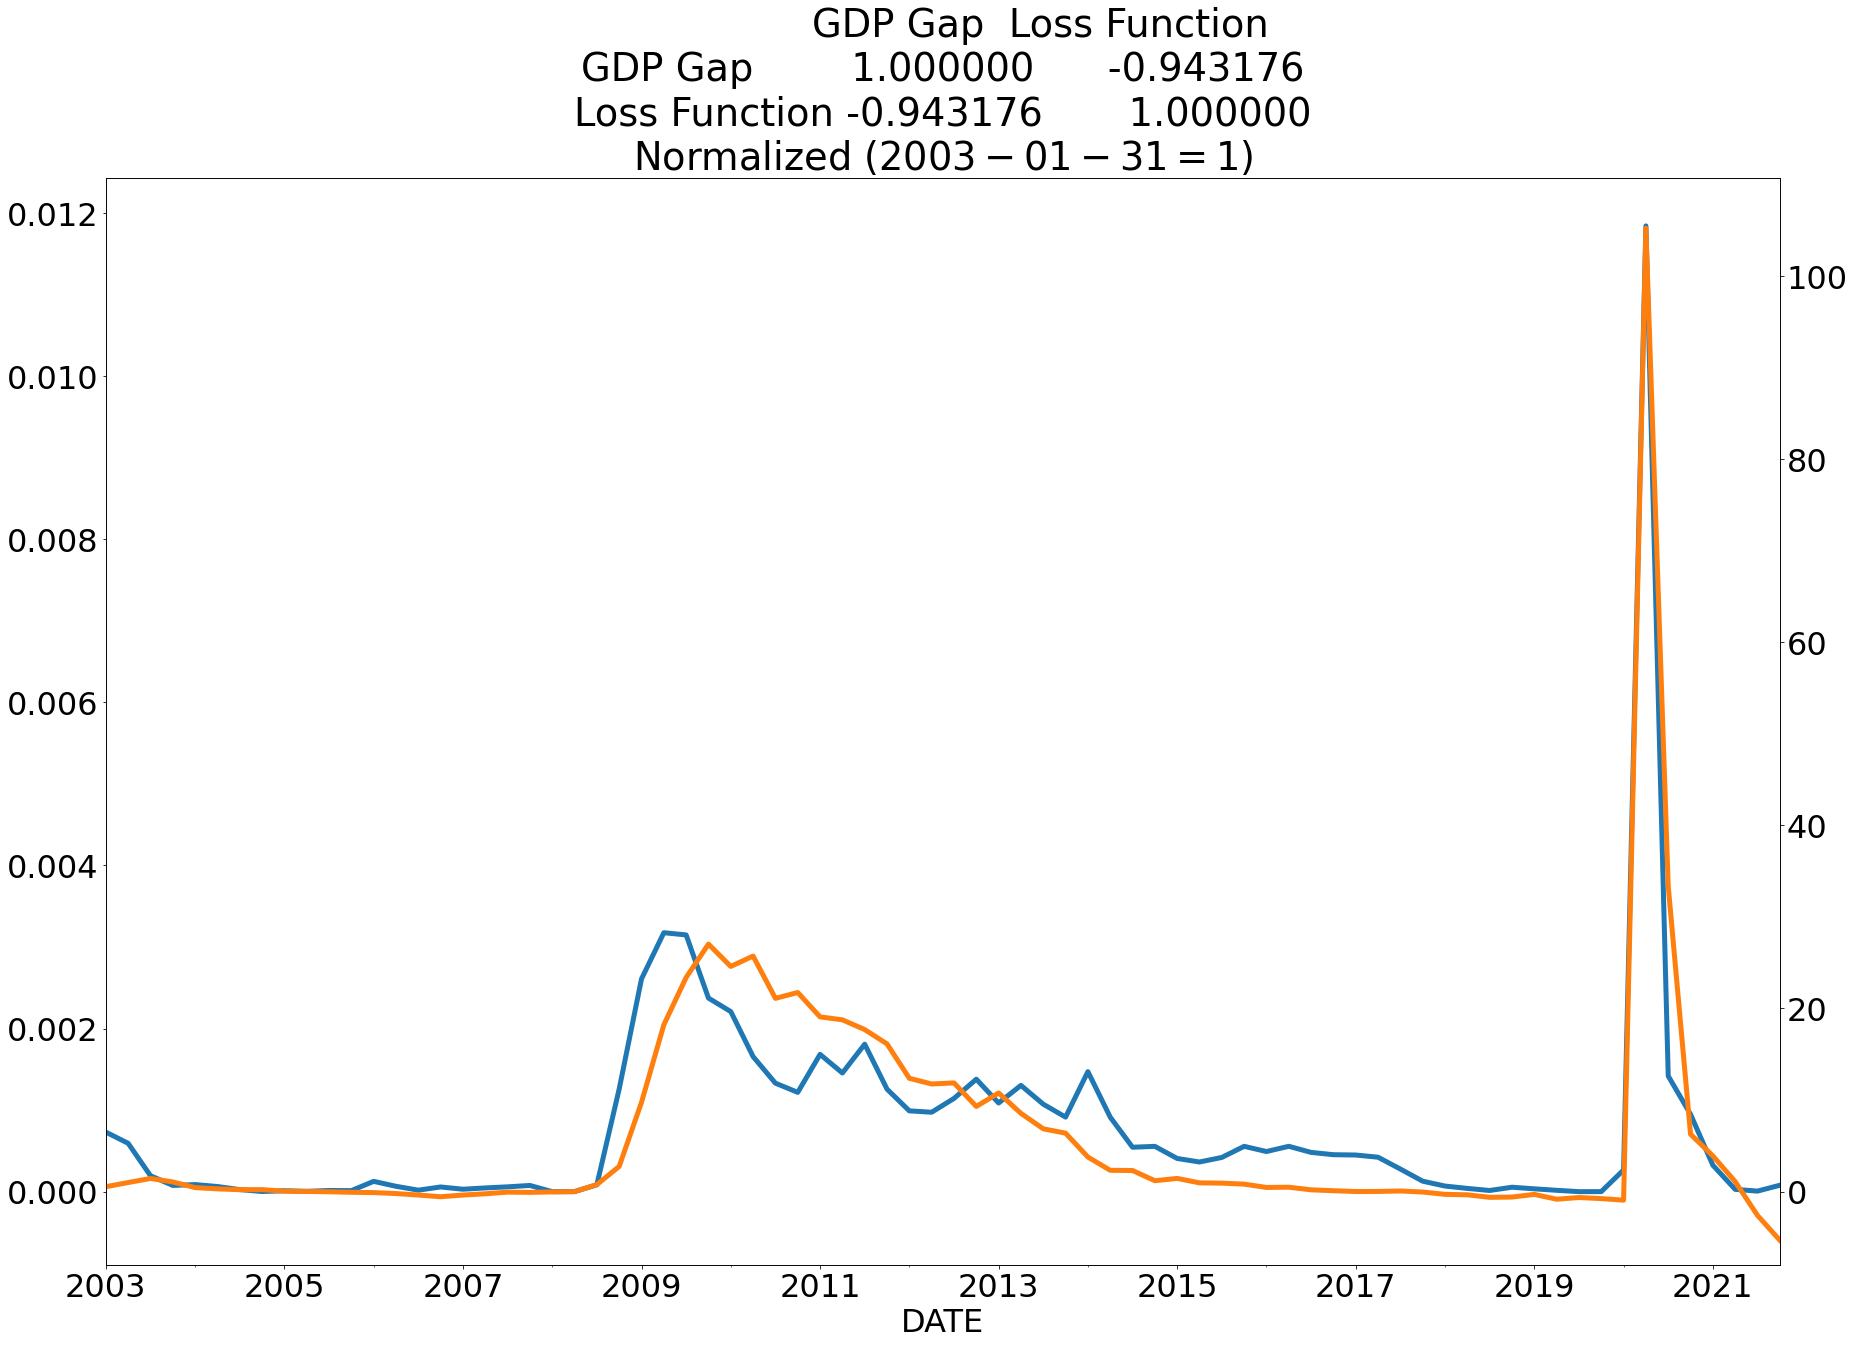

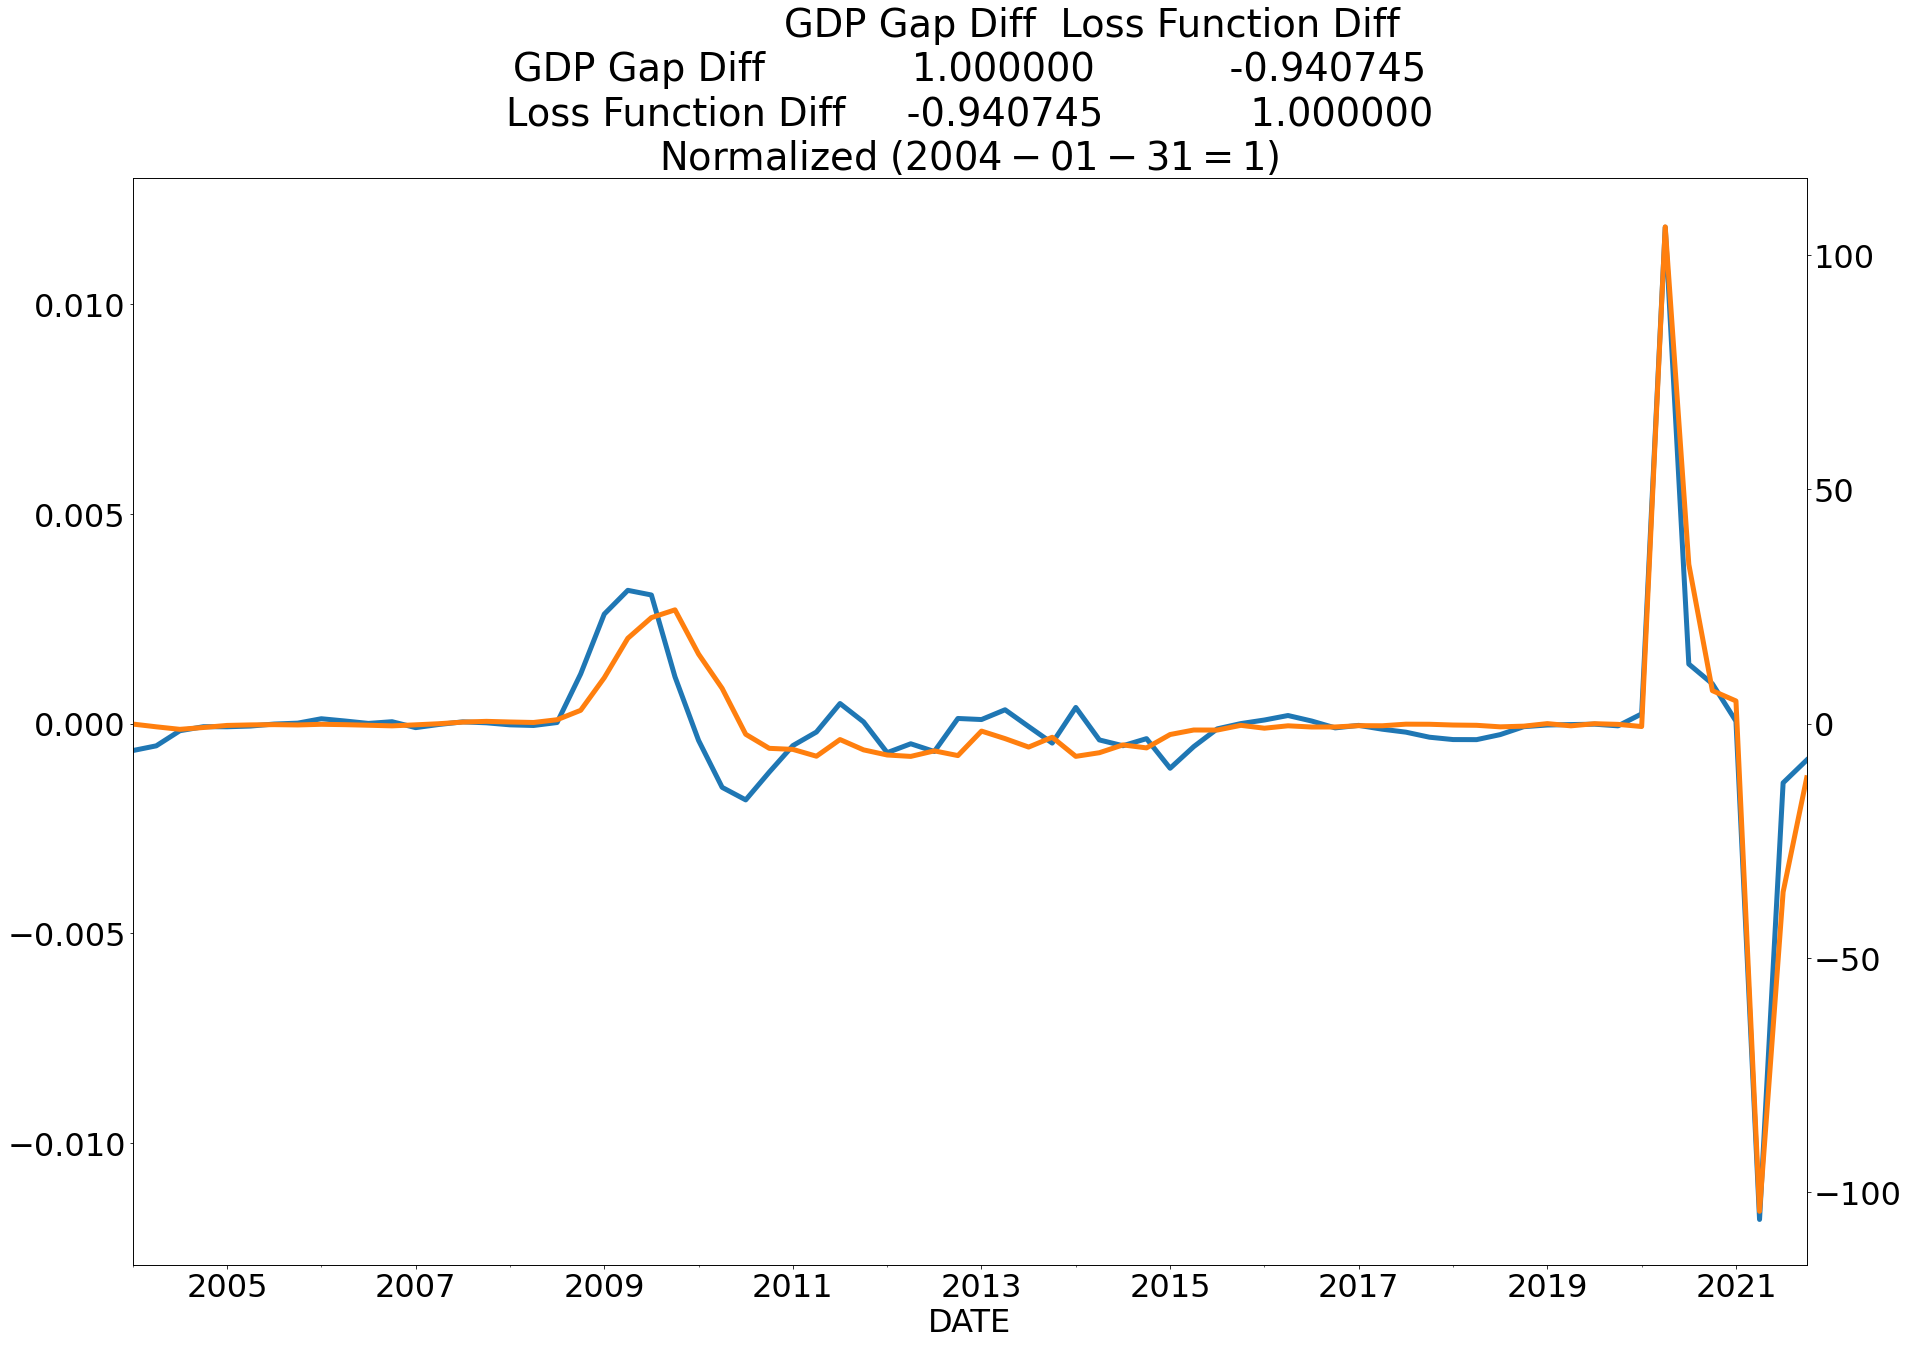

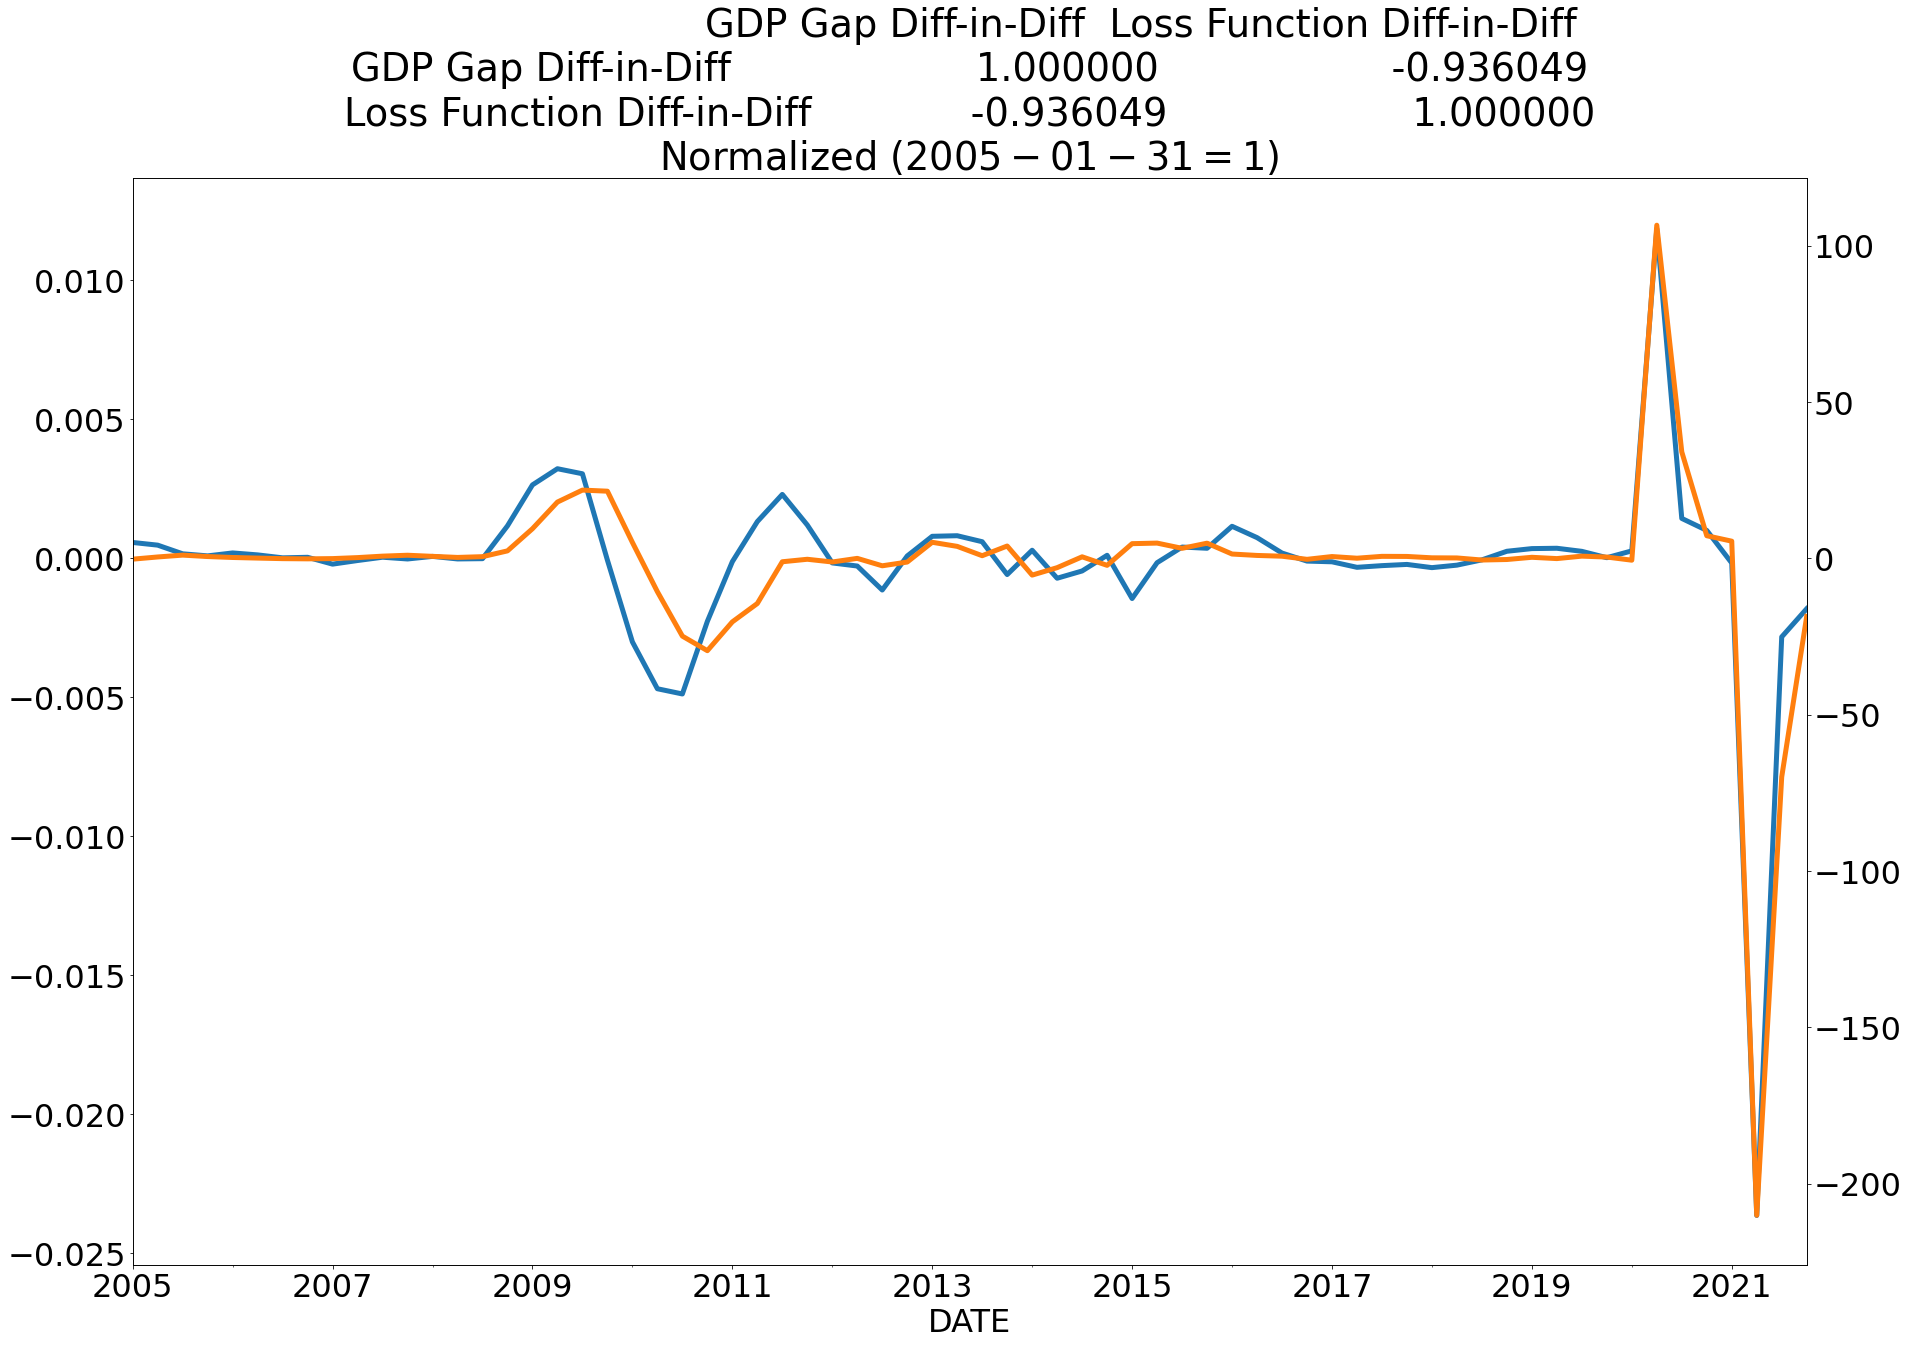

In [7]:
import dataframe_image as dfi
plt.rcParams.update({"font.size":32})
corr_dfs = {}
diffs = ["", " Diff", " Diff-in-Diff"]
for i in range(len(diffs)):
    diff= diffs[i]
    x = "GDP Gap" + diff 
    y = "Loss Function" + diff
    
    plot_vars =  [x, y]
    plot_data = data[plot_vars].dropna().loc[:"2021"]
#   plot_df.plot.scatter(x = x, y = y, ax = ax)
    corr_dfs[i] =plot_data.corr()
    fig, ax = plt.subplots(figsize = (30,20))
    ax2 = ax.twinx()

    plot_data[x].plot.line(linewidth = 5, 
                        ax = ax)
    plot_data[y].mul(-1).plot.line(linewidth = 5, 
                           color = "C1",
                        ax = ax2)
    ax.set_title(str(plot_data.corr()) + "\nNormalized ($" + str(list(plot_data.index)[0])[:10] + " = 1$)")
    align_yaxis(ax, 0, ax2, 0)    
    print(plot_data.corr())

In [8]:
corr_dfs[0].style.background_gradient(cmap='coolwarm')

,GDP Gap,Loss Function
GDP Gap,1.000000,-0.943176
Loss Function,-0.943176,1.000000


In [9]:
corr_dfs[1].style.background_gradient(cmap='coolwarm')

,GDP Gap Diff,Loss Function Diff
GDP Gap Diff,1.000000,-0.940745
Loss Function Diff,-0.940745,1.000000


In [10]:
corr_dfs[2].style.background_gradient(cmap='coolwarm')

,GDP Gap Diff-in-Diff,Loss Function Diff-in-Diff
GDP Gap Diff-in-Diff,1.000000,-0.936049
Loss Function Diff-in-Diff,-0.936049,1.000000


C:\Users\JLCat\AppData\Local\Temp\ipykernel_16156\1318250684.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(round(y,2))+ "%" for y in y_vals])


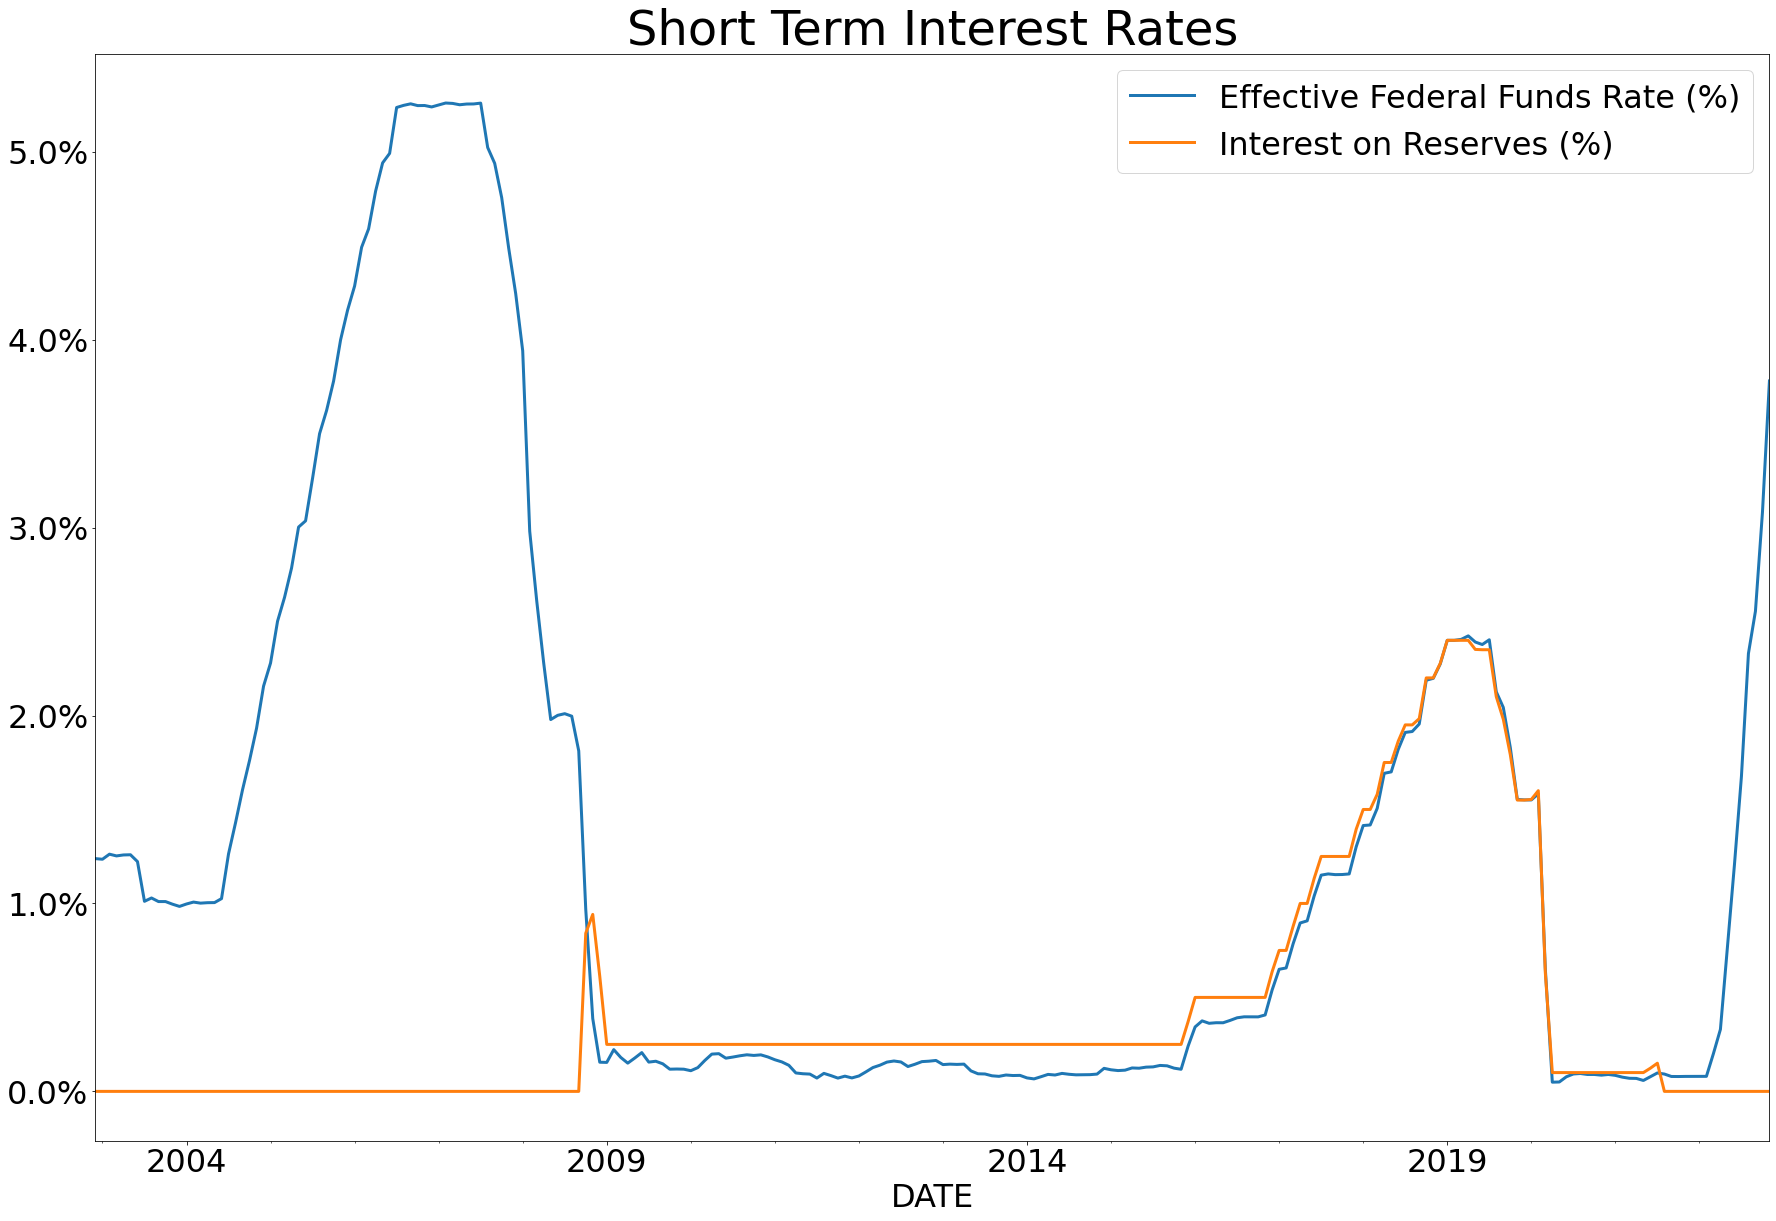

In [11]:
interest_vars = ["Effective Federal Funds Rate (%)",
                   "Interest on Reserves (%)"]
fig, ax = plt.subplots(figsize = (30,20))
data[interest_vars].plot.line(legend=True, linewidth = 3, ax = ax)
y_vals = ax.get_yticks()
ax.set_yticklabels([str(round(y,2))+ "%" for y in y_vals])  
ax.set_title("Short Term Interest Rates", fontsize = 48)
data[["Date"] + interest_vars].to_json("shortTermRates.json", orient="records")

In [12]:
keys = list(data.keys())
interest_rates = ["Effective Federal Funds Rate (%)",
                   "Interest on Reserves (%)",
                   "1 Month Treasury Rate (%)"]
plot_data = data.copy()
for key, val in data.items():
    if key not in interest_rates:
        try:
            plot_data[key] = val.div(10**6)
        except:
            continue

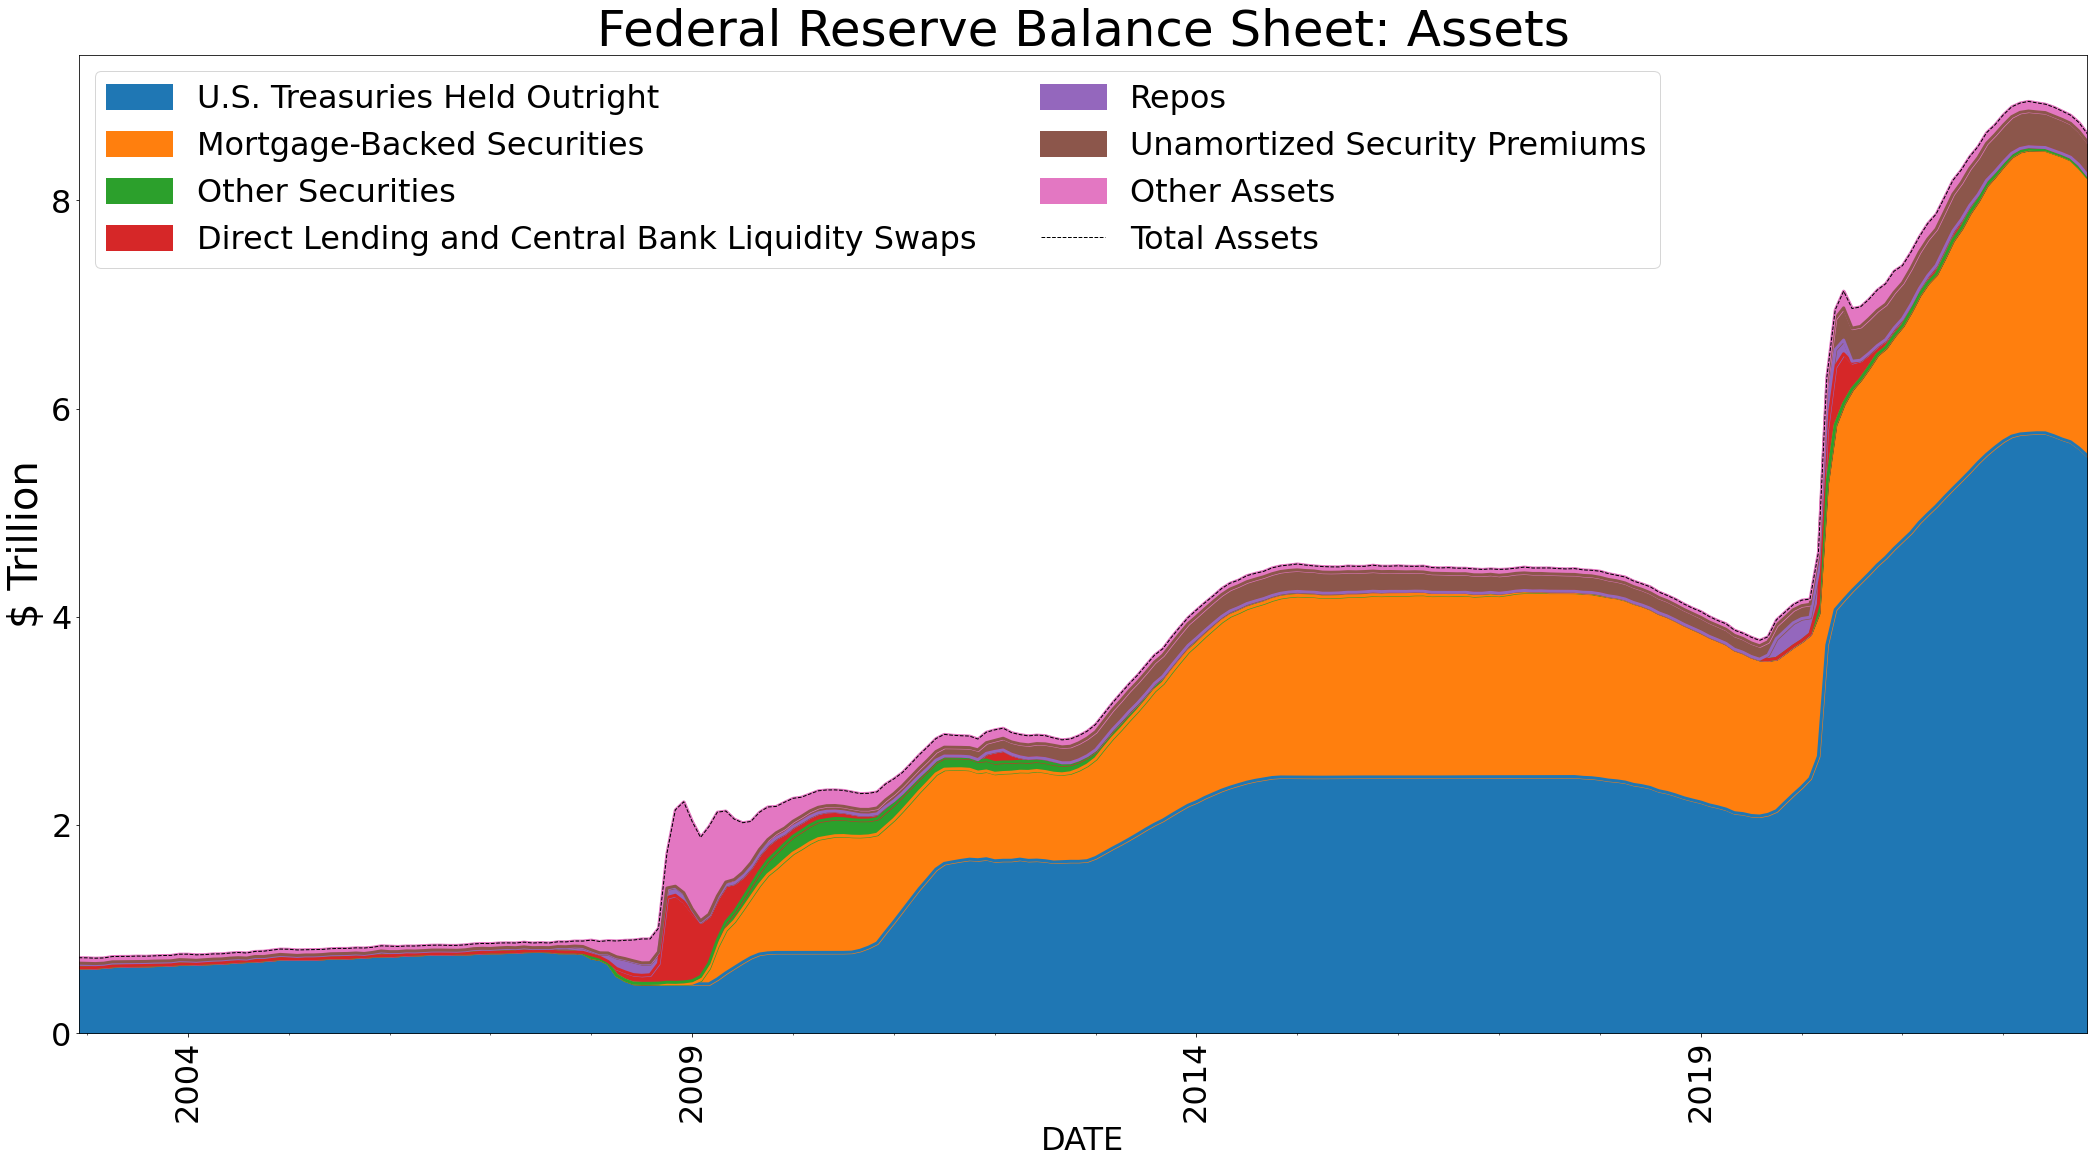

In [13]:
account_vars = ["U.S. Treasuries Held Outright",
               "Mortgage-Backed Securities",
               "Other Securities",
               "Direct Lending and Central Bank Liquidity Swaps",
               "Repos",
               "Unamortized Security Premiums",
               "Other Assets"]
figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
plot_data[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax)
# change y vals from mil to tril
total_var = "Total Assets"
plot_data[total_var].plot.line(linewidth = 1, 
                             ax = ax, c = "k",
                             label = total_var, ls = "--")
plt.xticks(rotation = 90)
ax.legend(loc=2, ncol = 2)
ax.set_ylabel("$ Trillion", fontsize = 40)
ax.set_title("Federal Reserve Balance Sheet: Assets", fontsize = 50)
plot_data[[total_var] + account_vars].to_csv("FederalReserveAssets.csv")
plot_data[["Date"] + account_vars].to_json("fedAssets.json", orient = "records")

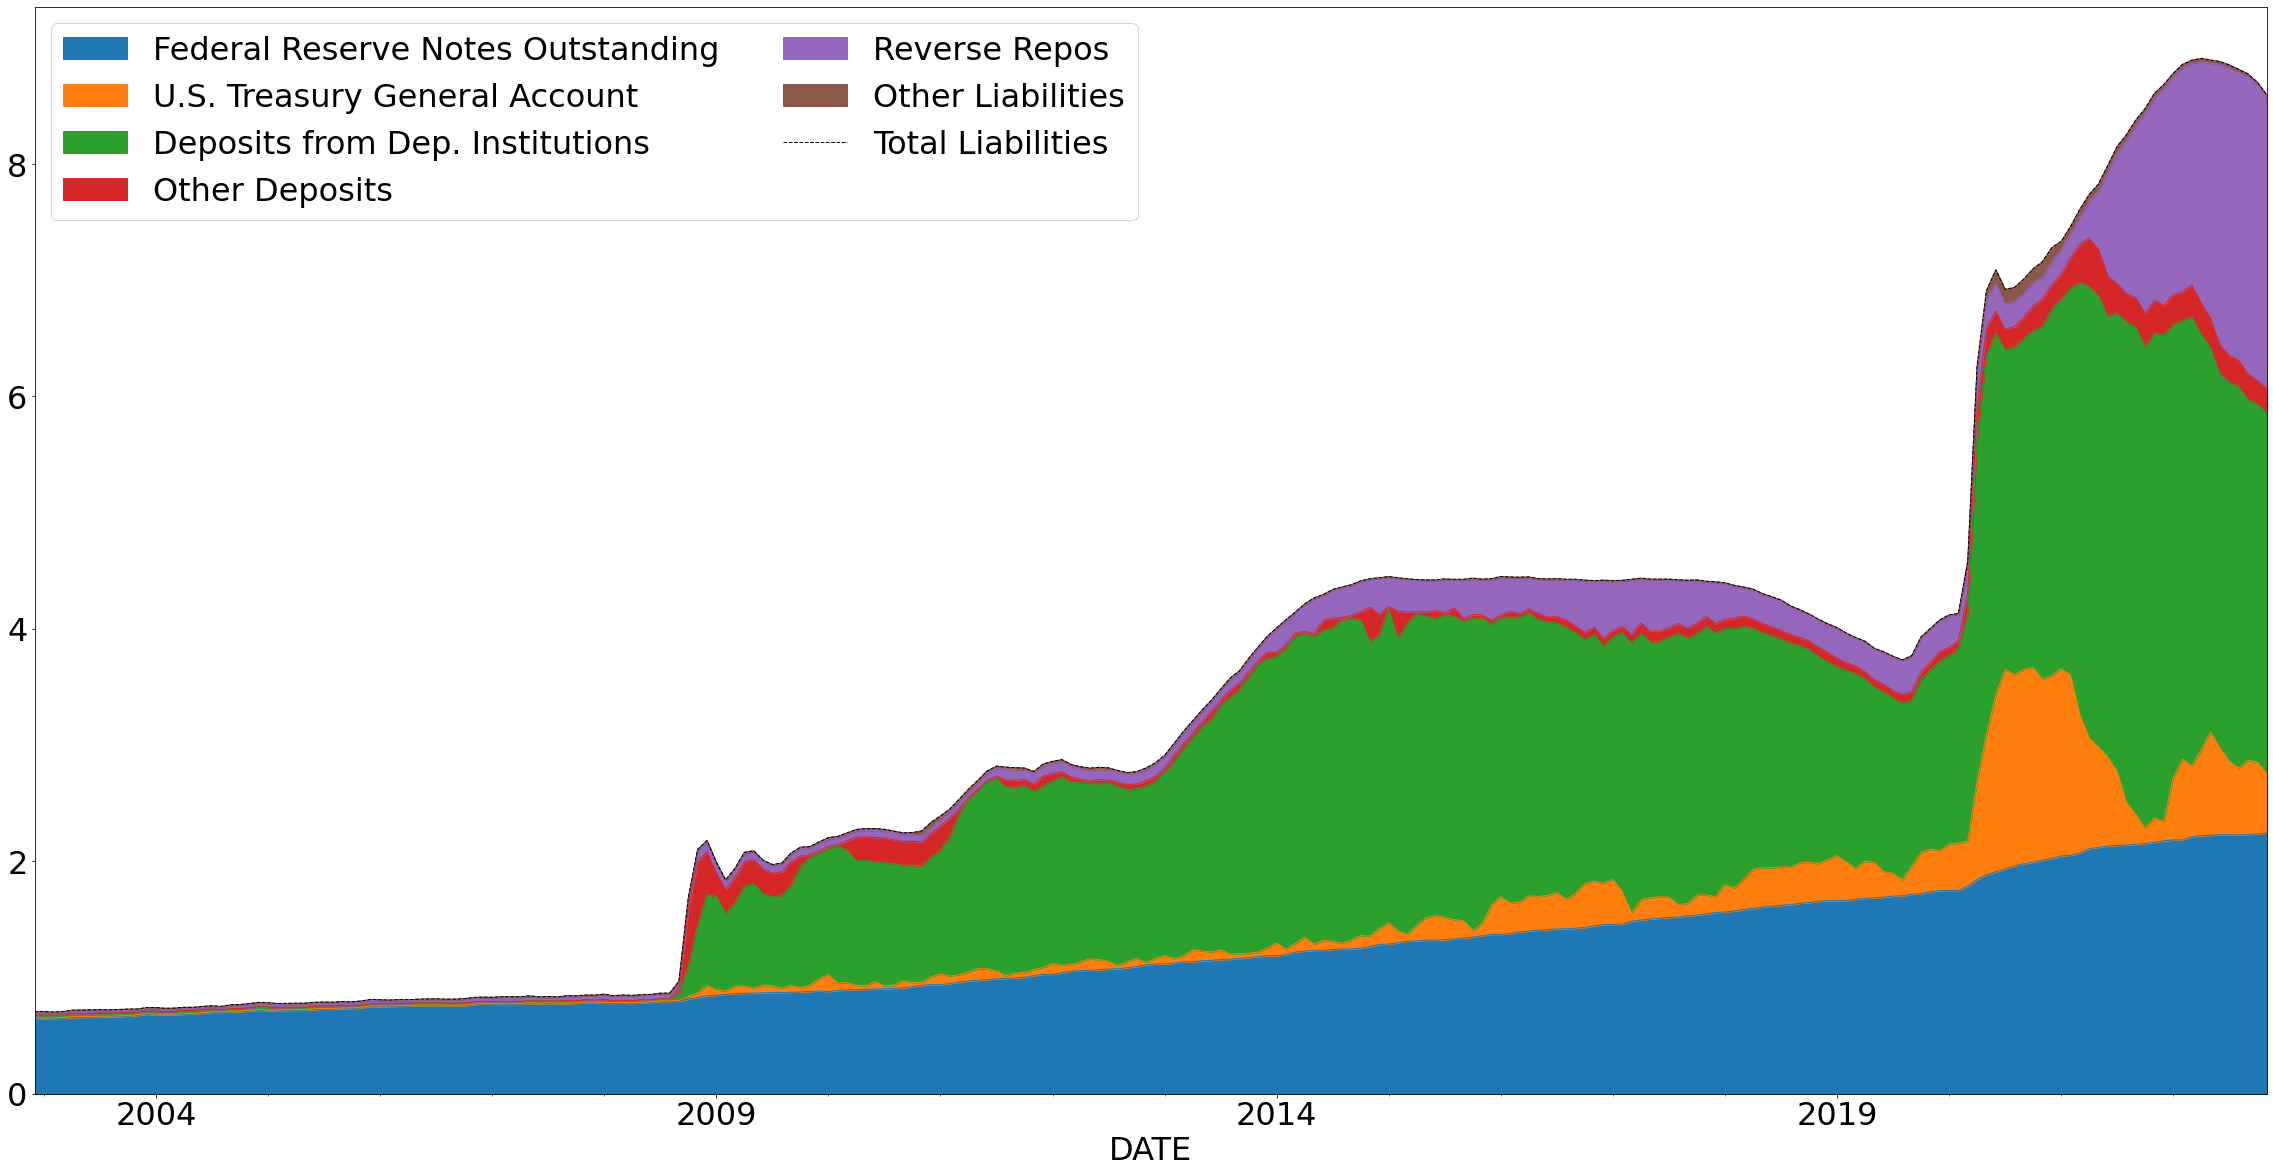

In [14]:
account_vars = ["Federal Reserve Notes Outstanding",
                "U.S. Treasury General Account",
                "Deposits from Dep. Institutions",
                "Other Deposits",
                "Reverse Repos",
                "Other Liabilities"]
total_var = "Total Liabilities"

plot_stacked_lines(
    plot_data,
    account_vars, linewidth = 1,
    total_var = "Total Liabilities")


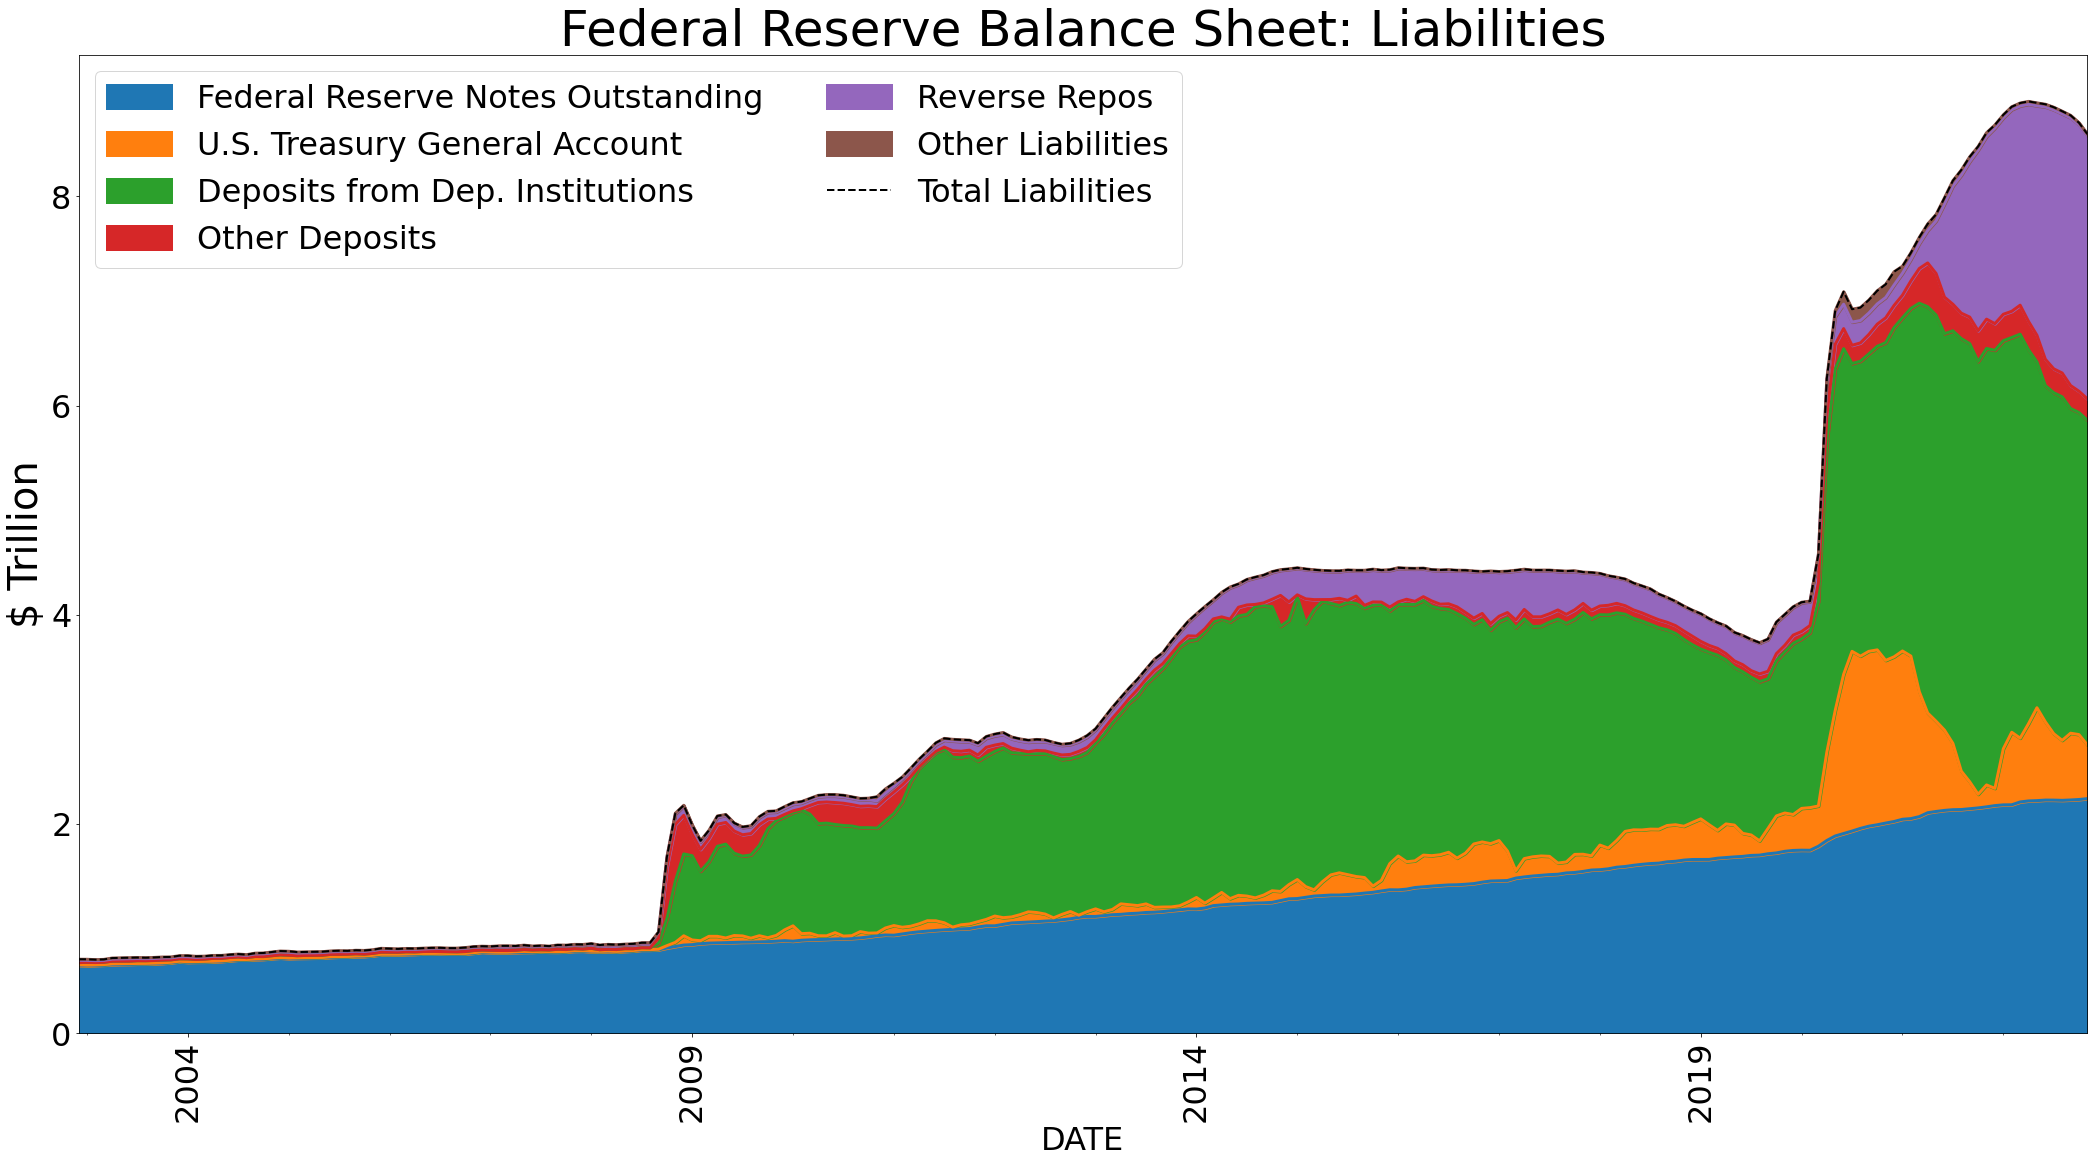

In [15]:
figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
plot_data[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax)
# change y vals from mil to tril
total_var = "Total Liabilities"
plot_data[total_var].plot.line(linewidth = 2, 
                             ax = ax, c = "k",
                             label = total_var, ls = "--")
plt.xticks(rotation = 90)
ax.legend(loc=2, ncol = 2)
ax.set_ylabel("$ Trillion", fontsize = 40)
ax.set_title("Federal Reserve Balance Sheet: Liabilities", fontsize = 50)
plot_data[[total_var] + account_vars].to_csv("FederalReserveLiabilities.csv")

C:\Users\JLCat\AppData\Local\Temp\ipykernel_16156\2968070503.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(val * 100)) + "% " for val in ax.get_yticks()], fontsize = 45)


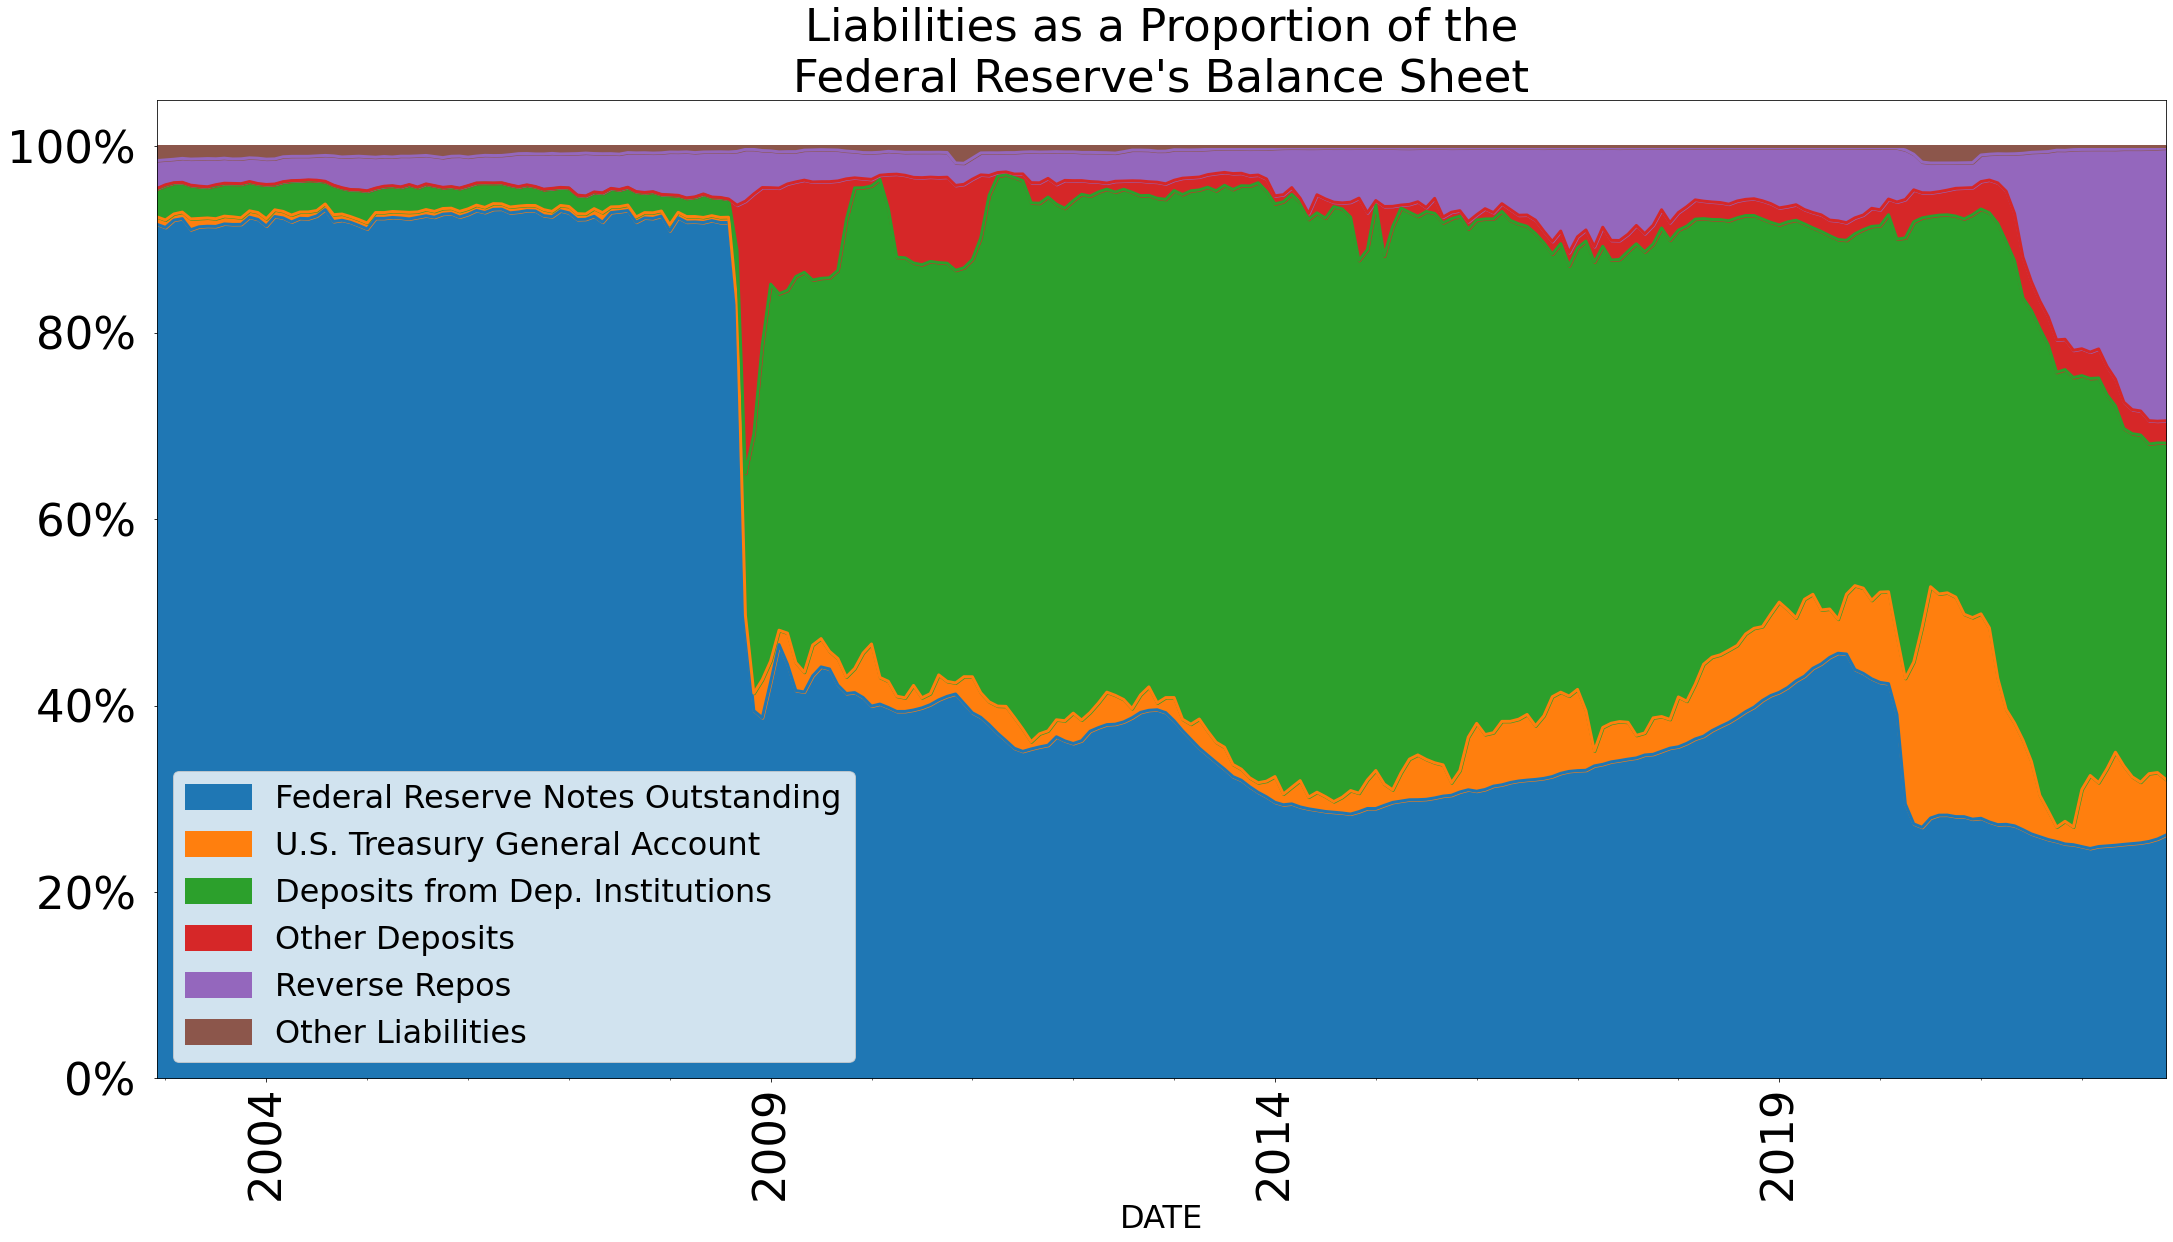

In [16]:
plt.rcParams.update({"font.size":32})
df = plot_data.copy()
for key in account_vars:
    df[key] = df[key].div(df["Total Liabilities"])
figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
df[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax)
plt.xticks(rotation= 90, fontsize = 45)
ax.set_yticklabels([str(int(val * 100)) + "% " for val in ax.get_yticks()], fontsize = 45)

#plt.yticks([int(tick * 100) for tick in ax.get_yticks() if tick <1.01])
plt.title("Liabilities as a Proportion of the\nFederal Reserve's Balance Sheet", fontsize =45)
plt.show()


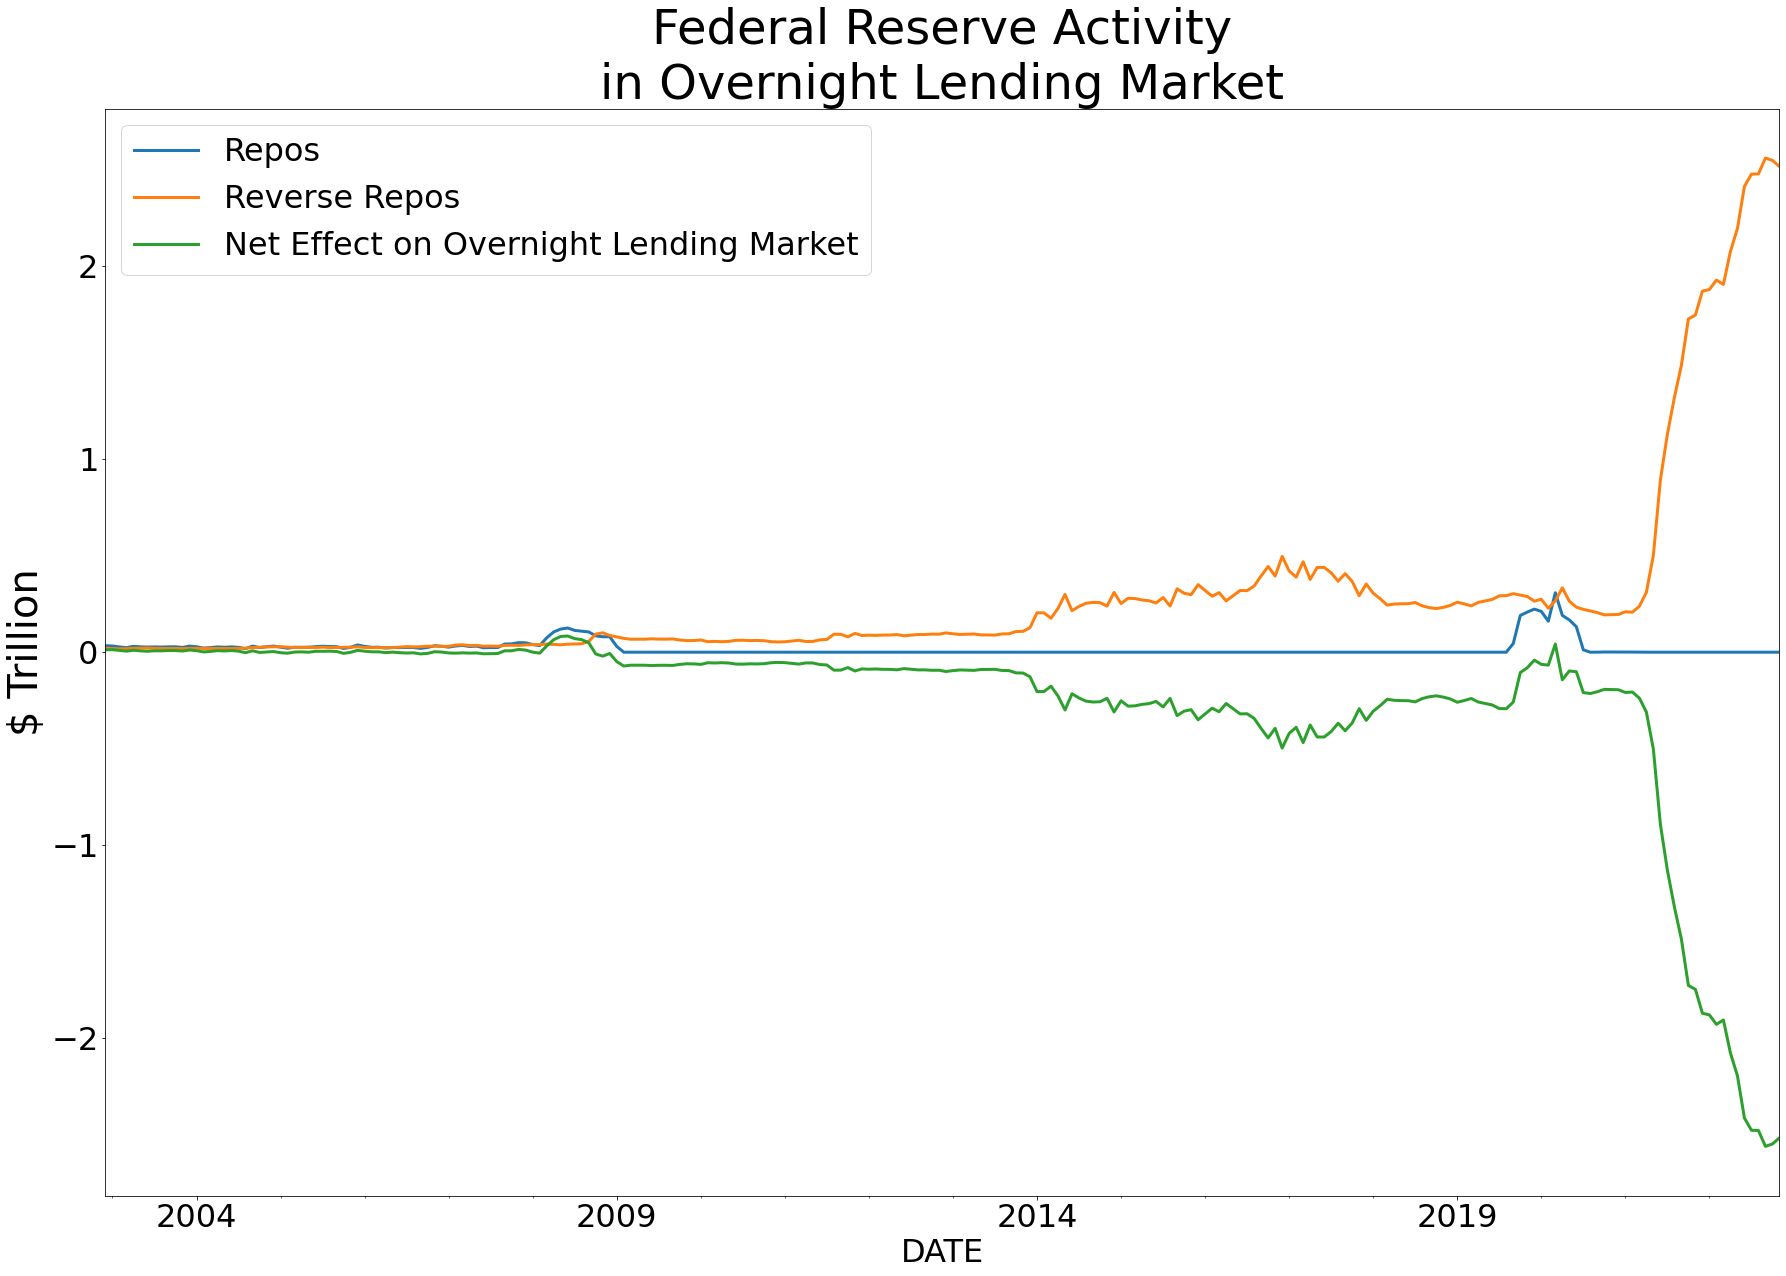

In [17]:
overnight_vars = ["Repos",
                  "Reverse Repos",
                  "Net Effect on Overnight Lending Market"]
fig, ax = plt.subplots(figsize = (30,20))
plot_data[overnight_vars].plot.line(legend=True, linewidth = 3, ax = ax)
ax.set_ylabel("$ Trillion", fontsize = 40)
ax.set_title("Federal Reserve Activity\nin Overnight Lending Market", fontsize = 48)
plot_data[["Date"] + overnight_vars].to_json("overnightLending.json", orient="records")


,Currency in Circulation / Total Assets,Effective Federal Funds Rate (%),Loss Function
DATE,,,
2022-01-31,25.322477,0.079355,10.495859
2022-02-28,25.086269,0.080000,12.100702
2022-03-31,25.270446,0.200968,12.030382
2022-04-30,25.362225,0.330000,9.886046
2022-05-31,25.429614,0.765484,9.006732
2022-06-30,25.532134,1.205000,9.914702
2022-07-31,25.625277,1.675806,8.119393
2022-08-31,25.693470,2.330000,9.044125
2022-09-30,25.859464,2.555000,10.996491


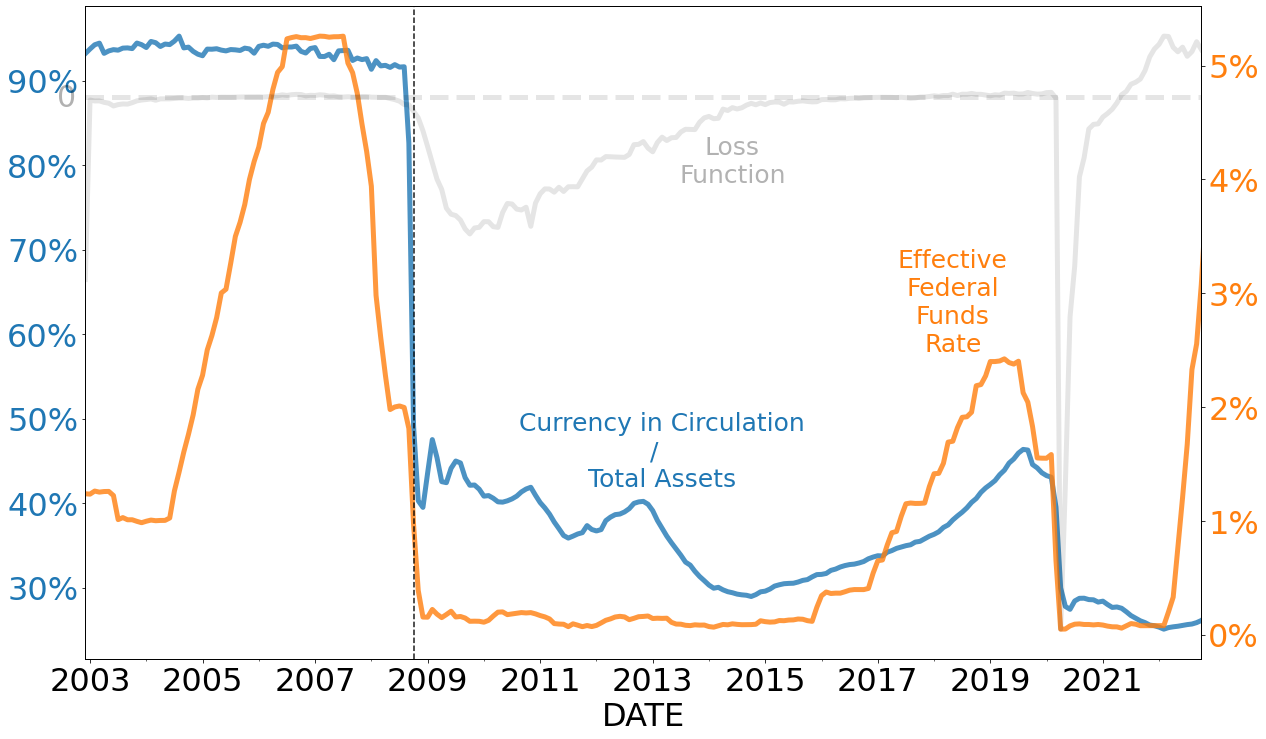

In [29]:
figsize = (20,12)
fig,ax = plt.subplots(figsize = figsize)

ax2 = ax.twinx()
ax3 = ax.twinx()
data[["Currency in Circulation / Total Assets"]].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .8,
                                                      ax = ax)
data[["Effective Federal Funds Rate (%)"]].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .8,
                                                      ax = ax2,
                                                        c = "C1")
data[["Loss Function"]].iloc[:-1].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .1,
                                                      ax = ax3,
                                                        c = "k")

ax.set_yticklabels([str(int(val )) + "%" for val in ax.get_yticks()], c = "C0")
ax2.set_yticklabels([str(int(val)) + "%" for val in ax2.get_yticks()], c = "C1")
ax3.set_yticklabels(ax3.get_yticks(), alpha = .2, c = "k")
ax3.set_yticks([])

ax3.axhline(0, c = "k", alpha = .1, linewidth = 5, ls = "--")

plt.axvline(datetime.datetime(2008,10,1), c = "k", ls = "--", alpha = .9)
ax.text(datetime.datetime(2013,3,1), 42, "Currency in Circulation\n/  \nTotal Assets", fontsize = 25, c = "C0", 
        ha = "center")
ax.text(datetime.datetime(2018,5,1), 58, "Effective\nFederal\nFunds\nRate", fontsize = 25, c = "C1", 
        ha = "center")
ax.text(datetime.datetime(2014,6,1), 78, "Loss\nFunction", fontsize = 25, c = "k", alpha = .3, 
        ha = "center")
ax3.text(datetime.datetime(2002,10,10), 0, "0", va = "center", fontsize = 30, c = "k", alpha = .3, 
        ha = "right")
# ax3.text(datetime.datetime.today(), 0, "0 ",va = "center", fontsize = 30, c = "k", alpha = .3, 
#         ha = "left")
data[["Currency in Circulation / Total Assets", "Effective Federal Funds Rate (%)", "Loss Function"]].to_csv("LossFunctionFFRAndC-A.csv")
data[["Currency in Circulation / Total Assets", "Effective Federal Funds Rate (%)", "Loss Function"]].loc["2022"]

C:\Users\JLCat\AppData\Local\Temp\ipykernel_16156\913973334.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(val )) + "%" for val in ax.get_yticks()], c = "C0")
C:\Users\JLCat\AppData\Local\Temp\ipykernel_16156\913973334.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([str(int(val)) + "%" for val in ax2.get_yticks()], c = "C1")
C:\Users\JLCat\AppData\Local\Temp\ipykernel_16156\913973334.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_yticklabels(ax3.get_yticks(), alpha = .2, c = "k")


,Currency in Circulation / Total Base,Effective Federal Funds Rate (%),Loss Function
DATE,,,
2022-01-31,36.592822,0.079355,10.495859
2022-02-28,36.954880,0.080000,12.100702
2022-03-31,36.801979,0.200968,12.030382
2022-04-30,38.567942,0.330000,9.886046
2022-05-31,40.637991,0.765484,9.006732
2022-06-30,41.372233,1.205000,9.914702
2022-07-31,41.161092,1.675806,8.119393
2022-08-31,40.762188,2.330000,9.044125
2022-09-30,42.137140,2.555000,10.996491


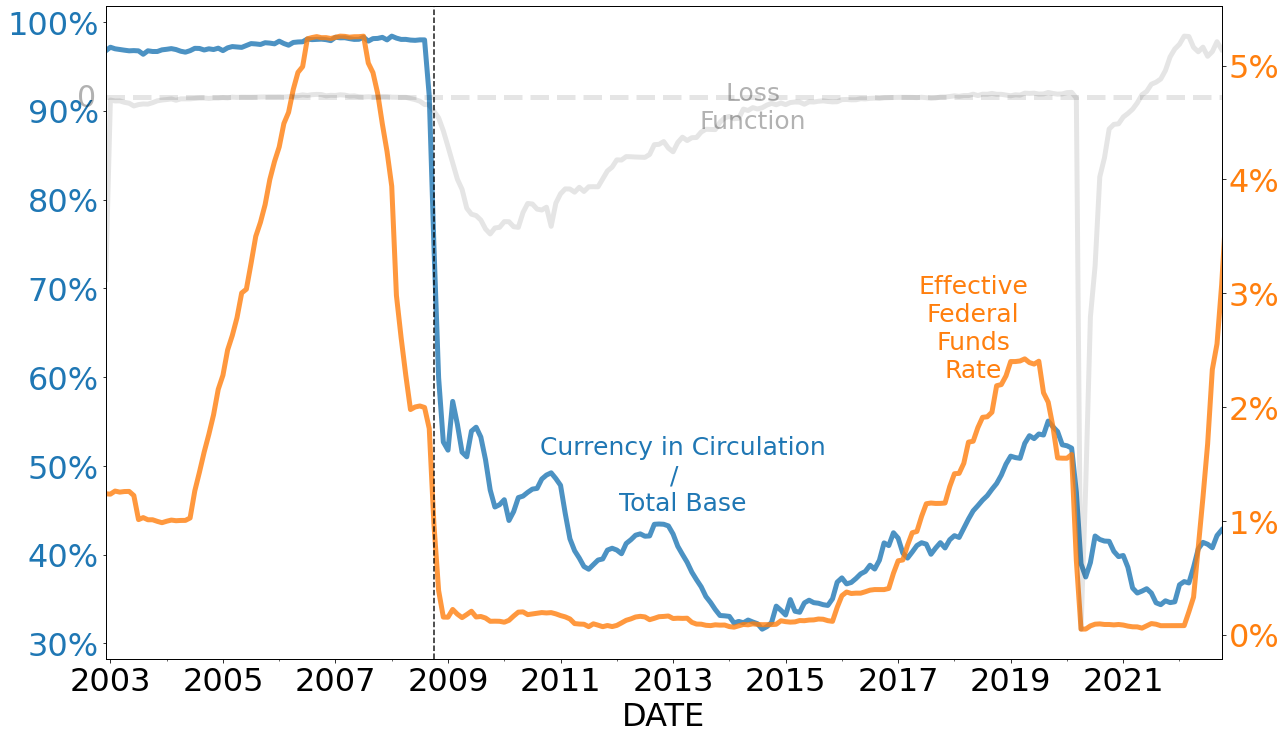

In [19]:
figsize = (20,12)
fig,ax = plt.subplots(figsize = figsize)

ax2 = ax.twinx()
ax3 = ax.twinx()
data[["Currency in Circulation / Total Base"]].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .8,
                                                      ax = ax)
data[["Effective Federal Funds Rate (%)"]].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .8,
                                                      ax = ax2,
                                                        c = "C1")
data[["Loss Function"]].iloc[:-1].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .1,
                                                      ax = ax3,
                                                        c = "k")

ax.set_yticklabels([str(int(val )) + "%" for val in ax.get_yticks()], c = "C0")
ax2.set_yticklabels([str(int(val)) + "%" for val in ax2.get_yticks()], c = "C1")
ax3.set_yticklabels(ax3.get_yticks(), alpha = .2, c = "k")
ax3.set_yticks([])

ax3.axhline(0, c = "k", alpha = .1, linewidth = 5, ls = "--")

plt.axvline(datetime.datetime(2008,10,1), c = "k", ls = "--", alpha = .9)
ax.text(datetime.datetime(2013,3,1), 45, "Currency in Circulation\n/  \nTotal Base", fontsize = 25, c = "C0", 
        ha = "center")
ax.text(datetime.datetime(2018,5,1), 60, "Effective\nFederal\nFunds\nRate", fontsize = 25, c = "C1", 
        ha = "center")
ax.text(datetime.datetime(2014,6,1), 88, "Loss\nFunction", fontsize = 25, c = "k", alpha = .3, 
        ha = "center")
ax3.text(datetime.datetime(2002,10,10), 0, "0", va = "center", fontsize = 30, c = "k", alpha = .3, 
        ha = "right")
# ax3.text(datetime.datetime.today(), 0, "0 ",va = "center", fontsize = 30, c = "k", alpha = .3, 
#         ha = "left")
data[["Currency in Circulation / Total Base", "Effective Federal Funds Rate (%)", "Loss Function"]].to_csv("LossFunctionFFRAndC-A.csv")

In [20]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
import copy
import pingouin
from scipy.stats import pearsonr
from datlib.ts_tests import *
from statsmodels.tsa.adfvalues import *
import warnings
warnings.simplefilter("ignore")
import statsmodels
statsmodels.__file__

C:\Users\JLCat\AppData\Roaming\Python\Python39\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\statsmodels\\__init__.py'

<AxesSubplot:xlabel='Currency in Circulation / Total Assets Diff-in-Diff', ylabel='Unemployment Rate Diff-in-Diff'>

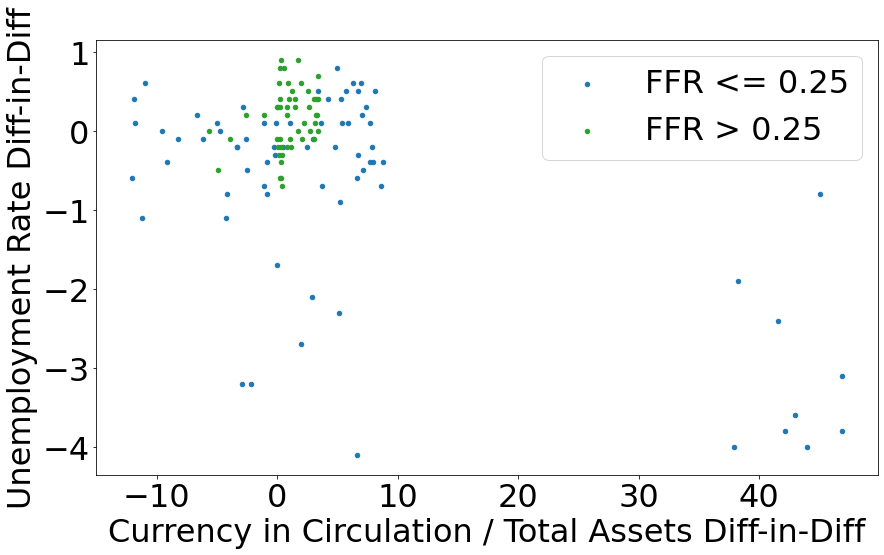

In [21]:
fig, ax = plt.subplots(figsize = (14,8))
data[data["Effective Federal Funds Rate (%)"] <= 0.25].loc["2010-01-31":"2020-02-29"].plot.scatter(x = "Currency in Circulation / Total Assets Diff-in-Diff", 
                                                 y = "Unemployment Rate Diff-in-Diff", 
                                                 c = "C0", 
                                                 ax = ax,
                                                label = "FFR <= 0.25")
data[data["Effective Federal Funds Rate (%)"] > 0.25].loc["2010-01-31":"2020-02-29"].plot.scatter(x = "Currency in Circulation / Total Assets Diff-in-Diff", 
                                                 y = "Unemployment Rate Diff-in-Diff", 
                                                 c = "C2", 
                                                 ax = ax,
                                                label = "FFR > 0.25")



(array([-15., -10.,  -5.,   0.,   5.,  10.,  15.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

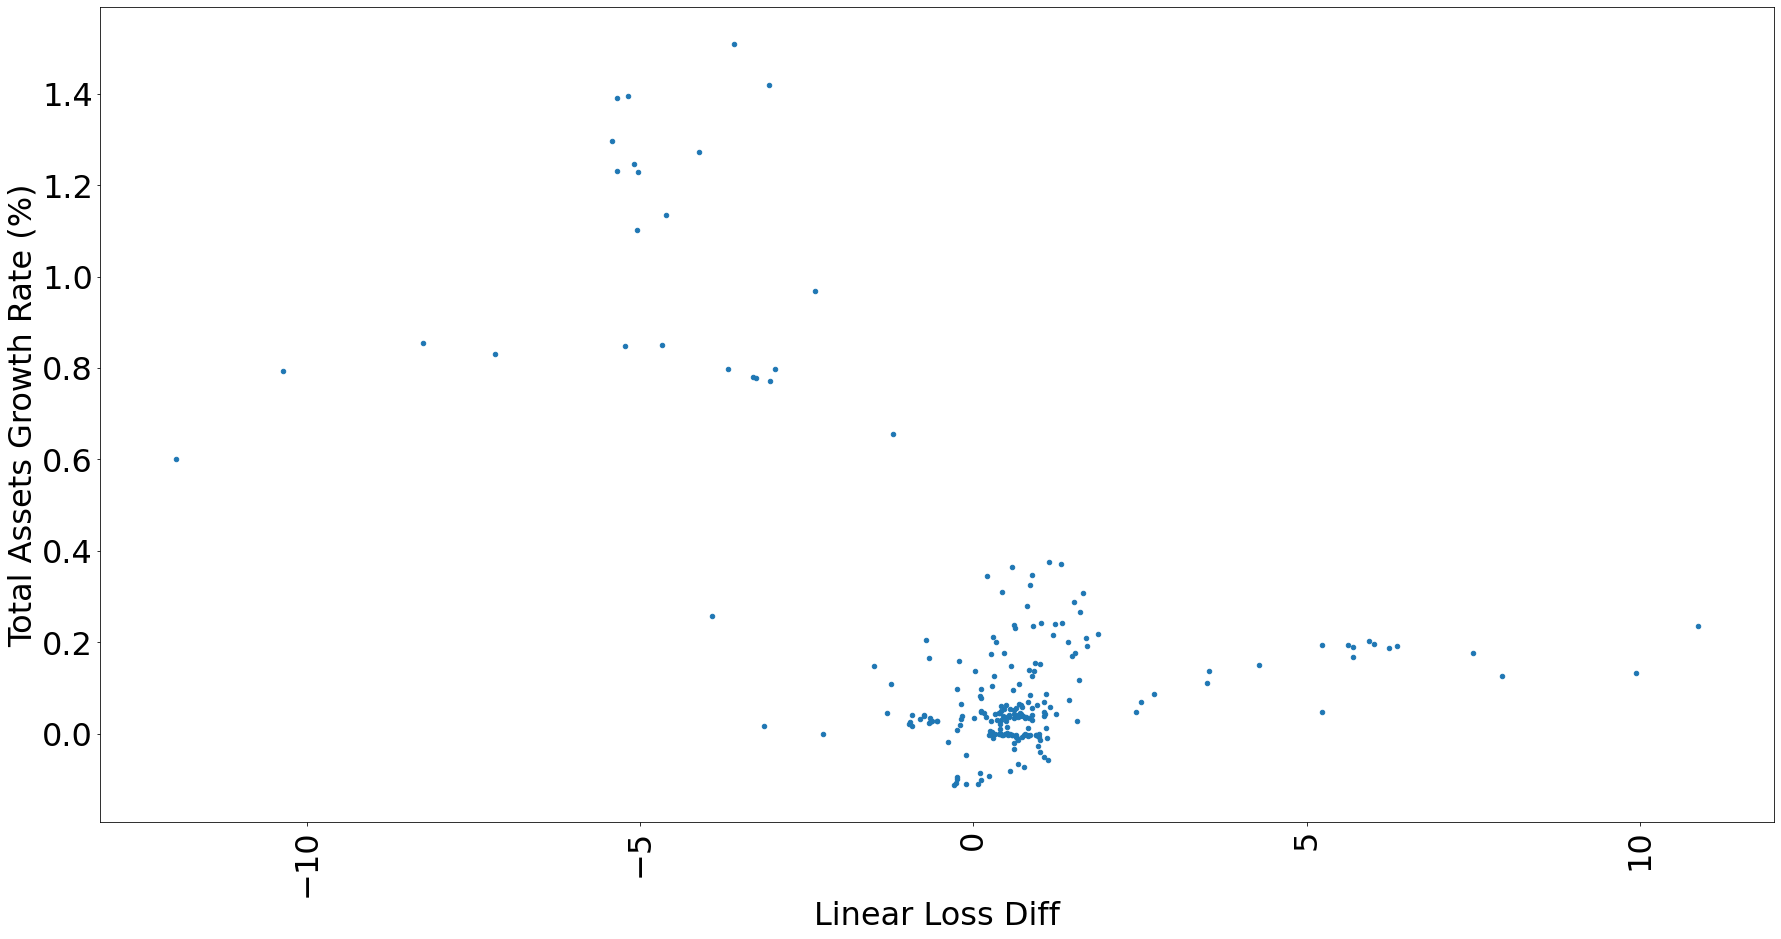

In [22]:
fig, ax = plt.subplots(figsize = (30,15))
data[["Linear Loss Diff", "Total Assets Growth Rate (%)"]].plot.scatter(x = "Linear Loss Diff", y = "Total Assets Growth Rate (%)", ax = ax)
plt.xticks(rotation=90)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

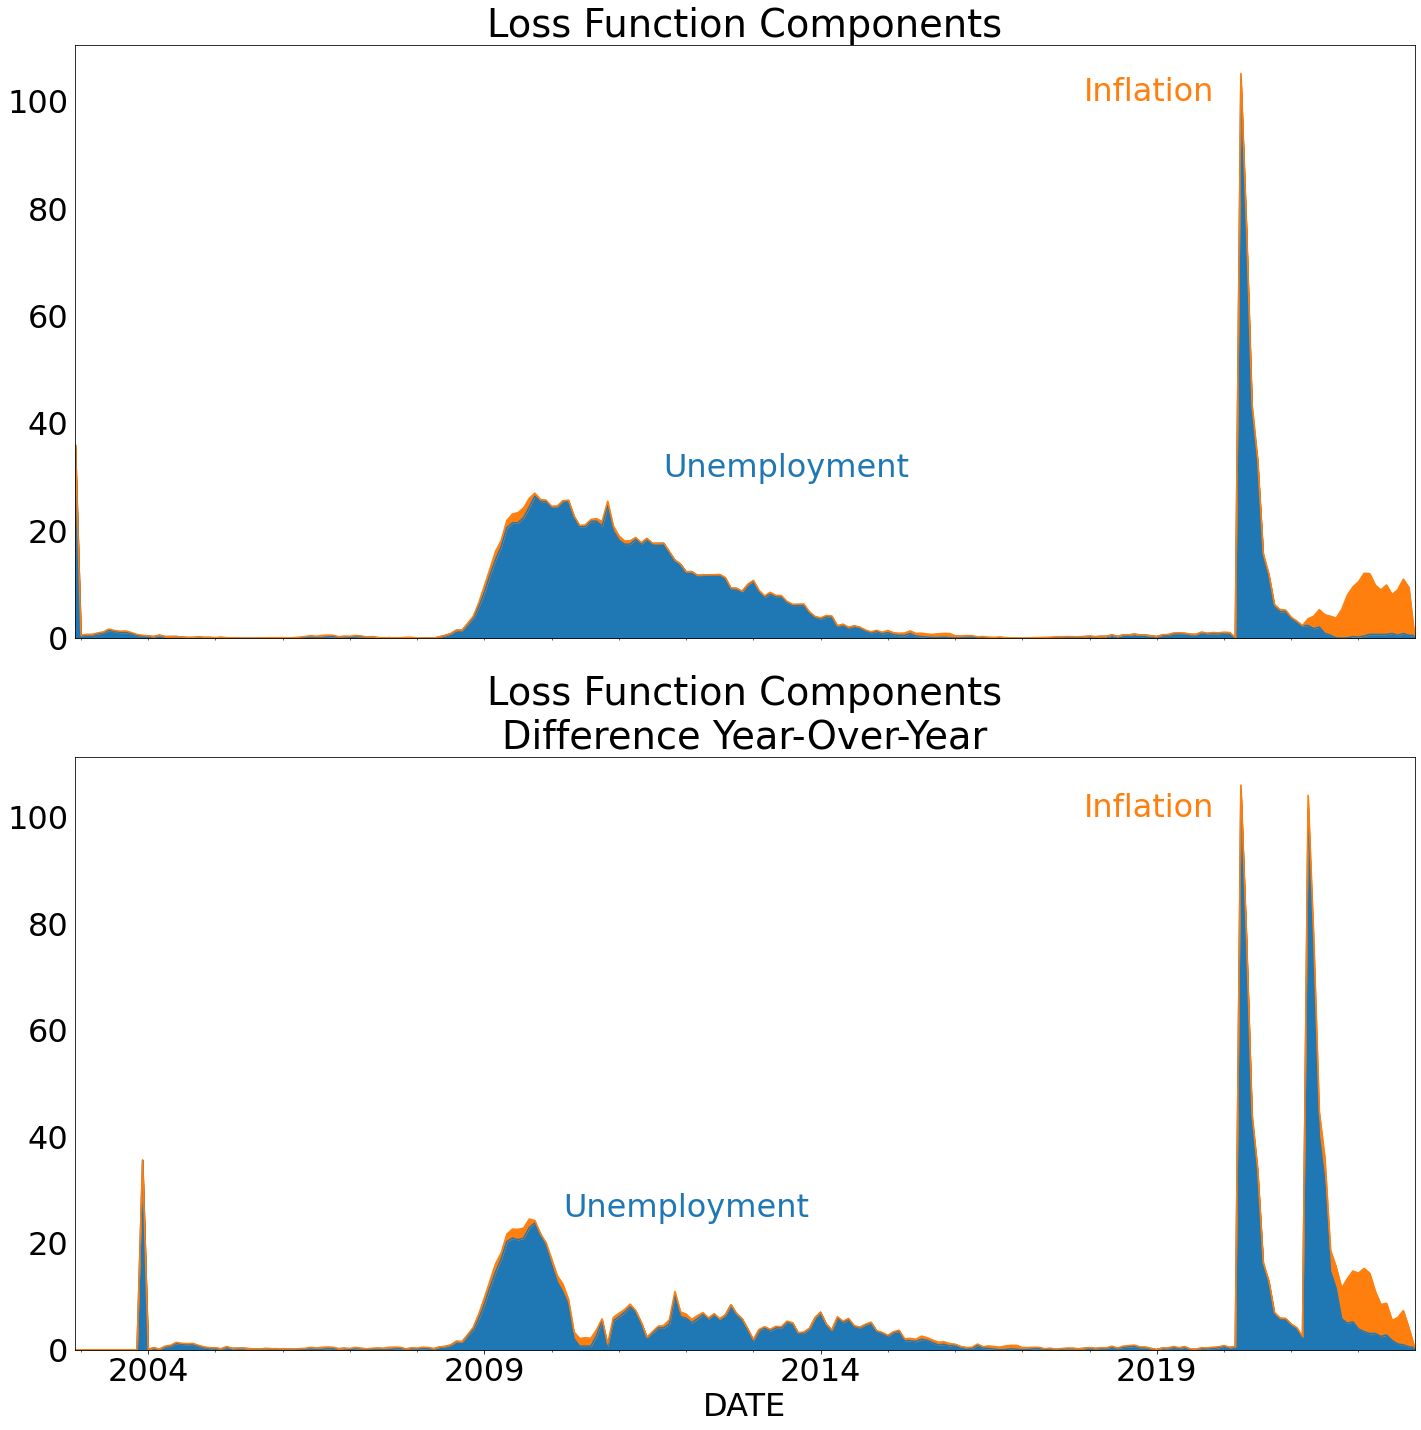

In [23]:
fig, ax = plt.subplots(2,1,figsize = (24,24))
abs(data[["Unemployment Loss Sq","Inflation Loss Sq"]]).plot.area(ax=ax[0], legend = False)
abs(data[["Unemployment Loss Sq","Inflation Loss Sq" ]].diff(12)).plot.area(ax=ax[1], legend = False)
ax[0].set_title("Loss Function Components")
ax[0].text(575, 100, "Inflation", color = "C1")
ax[0].text(500, 30, "Unemployment", color = "C0")
ax[0].set_xticks([],[])
ax[0].set_xlabel("")
plt.setp(ax[0].get_xticklines(), visible=False)

plt.setp(ax[0].get_yticklines(), visible=False)


ax[1].set_title("Loss Function Components\nDifference Year-Over-Year")
ax[1].text(575, 100, "Inflation", color = "C1")
ax[1].text(482, 25, "Unemployment", color = "C0")
plt.setp(ax[1].get_yticklines(), visible=False)


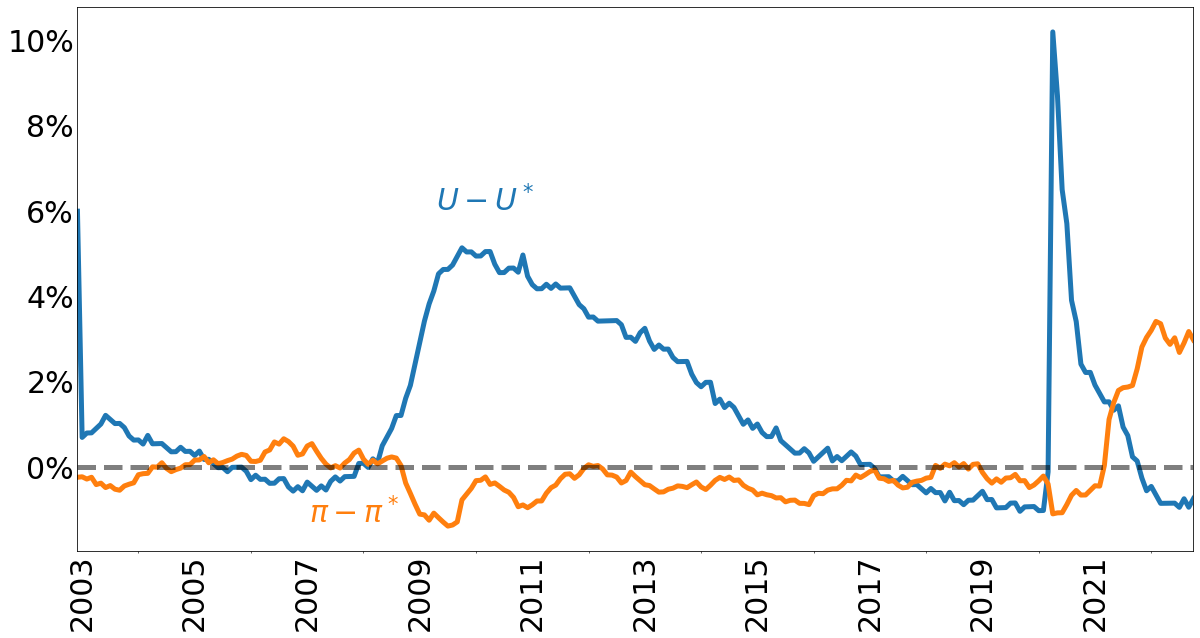

In [24]:
linewidth = 5
fig, ax = plt.subplots(figsize = (20,10))
data[["Unemployment Loss","Inflation Loss"]].dropna().plot.line(linewidth=linewidth,
                                                             ax=ax, 
                                                             legend = False)
# ax2 = ax.twinx()
# data[["Loss Function"]].plot.line(linewidth=linewidth,
#                                  ax = ax2,
#                                   color = "C2",
#                                  legend = False)

ax.set_xmargin(0)
ax.axhline(0, 
           linewidth = linewidth,
          color = "k",
          ls = "--",
          alpha = .5)
ax.text("2010-03-01", 6, "$U-U^*$", 
        ha = "center",
       fontsize =30,
       color = "C0")
ax.text("2007-11-01", -1.3, "$\pi - \pi^*$", 
        ha = "center",
       fontsize =30,
       color = "C1")
ax.tick_params(length = 0)

yticks = list(ax.get_yticks())
pct_yticks = [str(int(y)) + "%" for y in yticks]
ax.set_yticklabels(pct_yticks, fontsize = 30)
# ax2.set_yticklabels(pct_yticks, fontsize = 30)

plt.xticks(rotation=90, fontsize = 30)
ax.set_xlabel("")
ax.tick_params(length = 0)

data[["Unemployment Loss","Inflation Loss"]].dropna().to_csv("LossFunctionComponents.csv")

In [25]:
data["$V_{C_{Circ}}$"] = data["Nominal GDP"].div(data["Currency in Circulation"])
data["$C_{Circ}$"] =data["Currency in Circulation"]
plot_df = data[["Nominal GDP", "$C_{Circ}$", "$V_{C_{Circ}}$", "Total Assets", "CPI"]].resample("Q").mean().loc["2003":"2021-07-31"]
plot_df

,Nominal GDP,$C_{Circ}$,$V_{C_{Circ}}$,Total Assets,CPI
DATE,,,,,
2003-03-31,3.724710e+06,6.808855e+05,5.482260,7.232319e+05,183.366667
2003-06-30,3.770922e+06,6.898434e+05,5.488527,7.379987e+05,183.066667
2003-09-30,3.855556e+06,6.955508e+05,5.553500,7.416932e+05,184.433333
2003-12-31,3.924078e+06,7.077342e+05,5.600176,7.515598e+05,185.133333
2004-03-31,3.974482e+06,7.136417e+05,5.568436,7.563735e+05,186.700000
...,...,...,...,...,...
2020-06-30,6.545577e+06,1.924159e+06,3.468077,6.791227e+06,256.418333
2020-09-30,7.120809e+06,2.003012e+06,3.599517,6.994899e+06,259.437667
2020-12-31,7.234902e+06,2.055454e+06,3.546171,7.218179e+06,260.879000


<AxesSubplot:xlabel='DATE'>

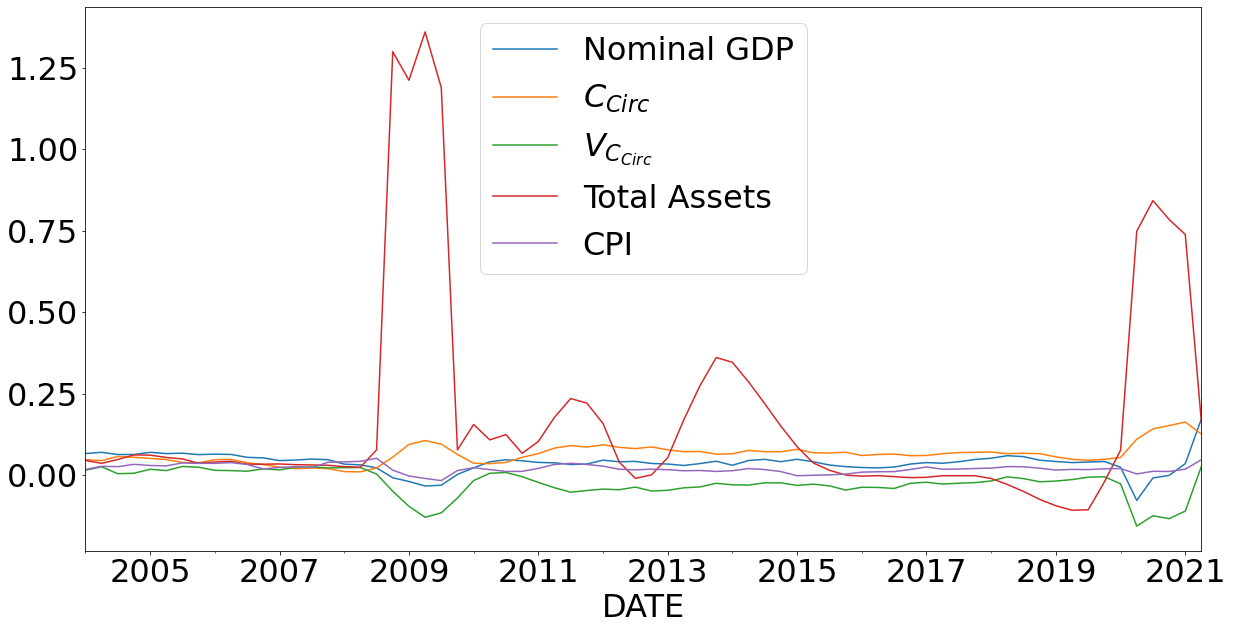

In [26]:
fig, ax = plt.subplots(figsize=(20,10))
plot_df.resample("Q").mean().pct_change(4).dropna().plot.line(ax = ax)

TypeError: matplotlib.axes._axes.Axes.scatter() got multiple values for keyword argument 'norm'

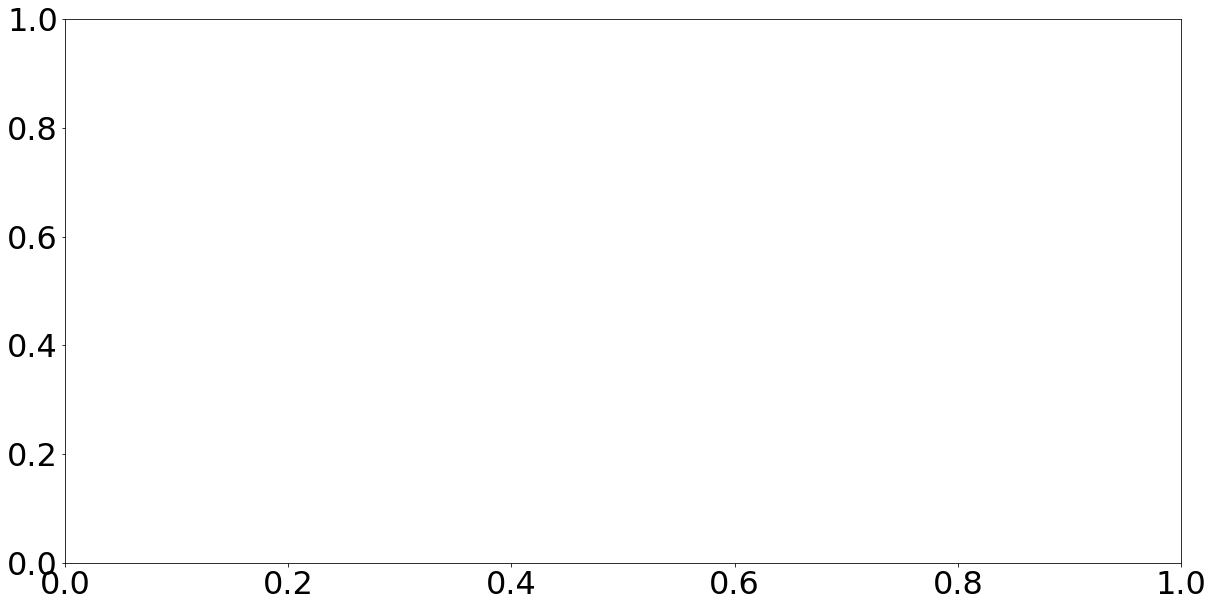

In [27]:
c_var = "Nominal GDP"
c_data =  plot_df.resample("Q").mean().pct_change(4)[c_var]
min_c = c_data.min()
max_c = c_data.max()
if abs(min_c) > abs(max_c):
    max_c = abs(min_c)
else:
    min_c = max_c * -1
norm = plt.cm.colors.Normalize(min_c,max_c)
fig, ax = plt.subplots(figsize=(20,10))
plot_df.resample("Q").mean().pct_change(4).dropna().plot.scatter(x = "$C_{Circ}$",
                                                                         y = "$V_{C_{Circ}}$", 
                                                                         c = "Nominal GDP",
                                                                         cmap = "coolwarm",
                                                                         norm = norm,
                                                                         ax = ax)
ax.set_yticklabels([str(round(y*100,2)) + "%" for y in ax.get_yticks()])
ax.set_xticklabels([str(round(x*100,2)) + "%" for x in ax.get_xticks()])
gcf = plt.gcf()
cax = gcf.get_axes()[1]
cax.set_yticklabels([str(round(c*100,2)) + "%" for c in cax.get_yticks()])


plt.title("$\Delta$ Year-over-Year")

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plot_df.resample("Q").mean().pct_change(4).dropna().plot.scatter(x = "Total Assets",
                                                                 y = "$V_{C_{Circ}}$", 
                                                                 c = "$C_{Circ}$",
                                                                 cmap = "viridis",
                                                                 ax = ax)
ax.set_yticklabels([str(round(y*100,2)) + "%" for y in ax.get_yticks()])
ax.set_xticklabels([str(round(x*100,2)) + "%" for x in ax.get_xticks()])
gcf = plt.gcf()
cax = gcf.get_axes()[1]
cax.set_yticklabels([str(round(c*100,2)) + "%" for c in cax.get_yticks()])



plt.title("$\Delta$ Year-over-Year")

In [ ]:
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mtick
c_var = "$C_{Circ}$"
c_data =  plot_df.resample("Q").mean().pct_change(4)[c_var]
min_c = c_data.min()
max_c = c_data.max()
if abs(min_c) > abs(max_c):
    max_c = abs(min_c)
else:
    min_c = max_c * -1

    
    
fig, ax = plt.subplots(figsize=(20,10))

cmap = cm.get_cmap('coolwarm_r')
norm = plt.cm.colors.Normalize(min_c,max_c)



# cbar.ax.set_ylabel(column, fontsize = 20)




plot_df.resample("Q").mean().pct_change(4).diff(4).dropna().plot.scatter(x = "Total Assets",
                                                                 y = "$V_{C_{Circ}}$",
                                                                         cmap = cmap,
                                                                         norm = norm,
                                                                 c = c_var,
                                                                 ax = ax)
ax.set_yticklabels([str(round(y*100,2)) + "%" for y in ax.get_yticks()])
ax.set_xticklabels([str(round(x*100,2)) + "%" for x in ax.get_xticks()])
gcf = plt.gcf()
cax = gcf.get_axes()[1]
cax.set_yticklabels([str(round(c*100,2)) + "%" for c in cax.get_yticks()])

plt.title("$\Delta$ Year-over-Year Difference")

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plot_df.resample("Q").mean().pct_change(4).dropna().plot.scatter(x = "Total Assets",
                                                                 y = "$C_{Circ}$", 
                                                                 c = "$V_{C_{Circ}}$",
                                                                 cmap = "viridis",
                                                                 ax = ax)
ax.set_yticklabels([str(round(y*100,2)) + "%" for y in ax.get_yticks()])
ax.set_xticklabels([str(round(x*100,2)) + "%" for x in ax.get_xticks()])
gcf = plt.gcf()
cax = gcf.get_axes()[1]
cax.set_yticklabels([str(round(c*100,2)) + "%" for c in cax.get_yticks()])



plt.title("$\Delta$ Year-over-Year")

In [ ]:
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mtick
c_var ="$V_{C_{Circ}}$"
c_data =  plot_df.resample("Q").mean().pct_change(4)[c_var]
min_c = c_data.min()
max_c = c_data.max()
if abs(min_c) > abs(max_c):
    max_c = abs(min_c)
else:
    min_c = max_c * -1

    
    
fig, ax = plt.subplots(figsize=(20,10))

cmap = cm.get_cmap('coolwarm_r')
norm = plt.cm.colors.Normalize(min_c,max_c)



# cbar.ax.set_ylabel(column, fontsize = 20)




plot_df.resample("Q").mean().pct_change(4).diff(4).dropna().plot.scatter(x = "Total Assets",
                                                                         y = "$C_{Circ}$", 
                                                                         c = c_var,
                                                                         cmap = cmap,
                                                                         norm = norm,
                                                                 ax = ax)
ax.set_yticklabels([str(round(y*100,2)) + "%" for y in ax.get_yticks()])
ax.set_xticklabels([str(round(x*100,2)) + "%" for x in ax.get_xticks()])
gcf = plt.gcf()
cax = gcf.get_axes()[1]
cax.set_yticklabels([str(round(c*100,2)) + "%" for c in cax.get_yticks()])

plt.title("$\Delta$ Year-over-Year Difference")

In [ ]:
data["Currency in Circulation / Total Assets"]

In [ ]:
data["Currency in Circulation / Total Base"].loc["2021"]

In [ ]:
fig, ax = plt.subplots(figsize = (20, 10))
check_df = data[["Total Assets","Total", "Currency in Circulation"]].loc["2007":"2008-09"]
check_df.rename(columns = {"Total":"Base", "Total Assets":"Assets"}, 
               inplace = True)
check_df = check_df.div(check_df.iloc[0])
i = 0
linestyles = ["-", "--", ":"]
for key, val in check_df.items():
    color = "C"  + str(i)
    ls = linestyles[i]
    val.plot.line(linewidth = 5, color = color, ls = ls, ax = ax)
    i += 1
ax.legend()
# list(data.keys())